***
## Importar librerías y dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')


# 1. Dataset explanation

#### **Dataset from a bank from a telemarketing campaing**

##### Demographic Information:
    age: Age of the individual.
    job: Type of job (e.g., blue-collar, management).
    marital: Marital status (e.g., single, married, divorced).
    education: Education level (e.g., primary, secondary, tertiary).
    default: Has credit in default? (binary: "yes","no")
##### Housing and Financial Information:
    housing: Has housing loan? (yes/no).
    loan: Has personal loan? (yes/no).
    default: has credit in default? (tiene un crédito en incumplimiento? es moroso?)
    contact: Contact method (e.g., cellular, telephone).
    month: Month of the last contact.
    day_of_week: Day of the week of the last contact.
    duration: Last contact duration in seconds.
    campaign: Number of contacts performed during this campaign for this client.
    pdays: Number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
    previous: Number of contacts performed before this campaign for this client.
    poutcome: Outcome of the previous marketing campaign (e.g., success, failure, unknown).

**__According to the dataset, the column "duration" should be removed because it highly affects the output (duration=0 --> 'no', other duration -->'yes'), and the duration is only known after the call is done.__**


##### Economic Indicators (they are macro-economical indicators):
    - emp.var.rate: Employment variation rate - QUARTERLY indicator of the variation in the number of employed people. Represented with floatings.(see cons.price.idx for more info.)
    - cons.price.idx: Consumer price index - monthly indicator of the variation in consumer prices. (Same as IPC in ARGENTINA). It is represented with floatings, e.g.: 1.1 means the employment increased by 1.1% ; -3.2 means the employment decreased by -3.2%.
    - cons.conf.idx: Consumer confidence index - monthly measure of consumer sentiment about the overall economic health of a country. It's often used as an indicator of future economic activity.
    - euribor3m: 3-month Euribor rate - interest rate at which banks in the Eurozone lend money to each other for a 3-month period. Different values can lead to higher/lower interest rates for consumers on loans and mortgages.
    - nr.employed: Number of employees - quarterly indicator of the total number of employed people.
##### Target Variable:
    y: Has the client subscribed a term deposit (yes/no)?. A term deposit is a deposit that a bank or financial insitution offers with a fixed rate in which your money will be returned back at a specific maturity time. In spanish, we call it "Plazo fijo".


In [5]:
data = pd.read_excel('bankdata.xlsx')
data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,Year,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,2008,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,2008,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,2008,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,2008,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,2008,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,2010,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,2010,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,2010,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,2010,yes


---------------------------------------------------------------------------------------------------------
# 2. Transformacion de datos

- Mapear columna mes(que no sea str sino int). Notar que no están todos los meses, y que los que están son irregulares. Debemos identificar de alguna forma a qué año corresponde c/u para crear una línea temporal.


In [8]:
dic={   'jan': 1,
        'feb': 2,
        'mar': 3,  
        'apr': 4,
        'may': 5,
        'jun': 6,
        'jul': 7,
        'aug': 8,
        'sep': 9,
        'oct': 10,
        'nov': 11,
        'dec': 12}
data['month'] =data['month'].replace(dic)

In [9]:
data.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,Year,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,5,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,2008,no
1,57,services,married,high.school,unknown,no,no,telephone,5,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,2008,no
2,37,services,married,high.school,no,yes,no,telephone,5,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,2008,no


- Generamos una columna para obtener el dato de inflación intermensual(surge de la resta de: ((IPC(mes) - IPC(mes-1)) / IPC(mes-1)) * 100. Para el primer mes deberíamos poner 0, porque no tenemos un valor previo. Para el resto podemos calcularlo.

In [11]:
dataCopy = data.copy()
dataCopy.rename(columns={'month': 'month_Column', 'Year': 'Year_Column'}, inplace=True)
agrupamiento = dataCopy.groupby(['Year_Column', 'month_Column'])['cons.price.idx'].mean()

df_resultado = agrupamiento.reset_index()

df_resultado['IPC_mes_anterior'] = df_resultado['cons.price.idx'].shift(1)

def calcular_variacion(row):
    if pd.isna(row['IPC_mes_anterior']):
        return 0
    else:
        return ((row['cons.price.idx'] - row['IPC_mes_anterior']) / row['IPC_mes_anterior']) * 100

df_resultado['inflation_variation'] = df_resultado.apply(calcular_variacion, axis=1)

df_resultado

,Year_Column,month_Column,cons.price.idx,IPC_mes_anterior,inflation_variation
0,2008,5,93.994,NaN,0.000000
1,2008,6,94.465,93.994,0.501096
2,2008,7,93.918,94.465,-0.579050
3,2008,8,93.444,93.918,-0.504696
4,2008,10,93.798,93.444,0.378837
5,2008,11,93.200,93.798,-0.637540
6,2008,12,92.756,93.200,-0.476395
7,2009,3,92.843,92.756,0.093794
8,2009,4,93.075,92.843,0.249884
9,2009,5,92.893,93.075,-0.195541


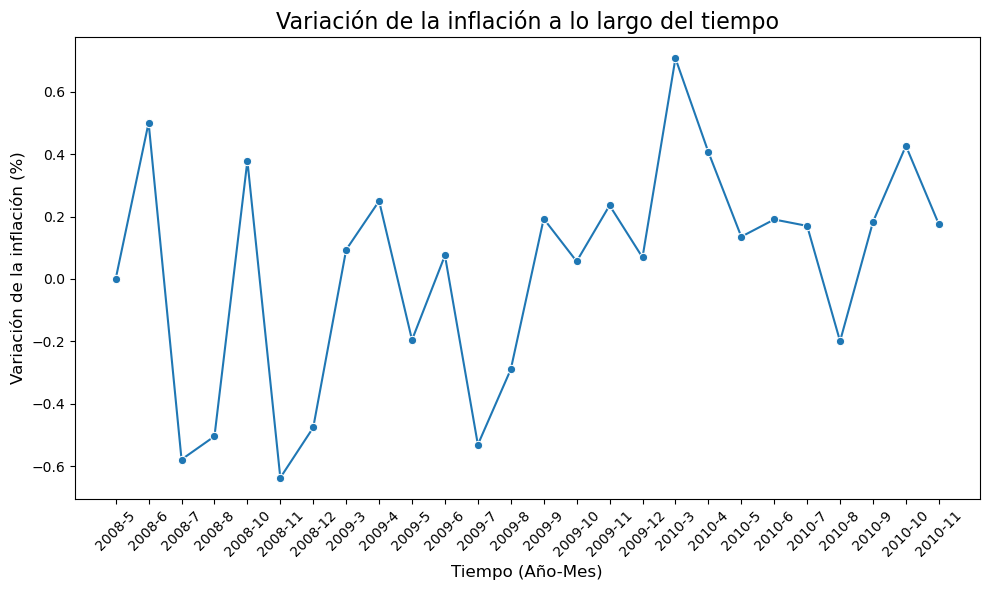

In [12]:
df_resultado['time'] = df_resultado['Year_Column'].astype(str) + '-' + df_resultado['month_Column'].astype(str)

plt.figure(figsize=(10, 6))

sns.lineplot(data=df_resultado, x='time', y='inflation_variation', marker='o')

plt.title('Variación de la inflación a lo largo del tiempo', fontsize=16)
plt.xlabel('Tiempo (Año-Mes)', fontsize=12)
plt.ylabel('Variación de la inflación (%)', fontsize=12)

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

- Mergeamos el data set data con df_resultado para poder tener el dato de variacion_inflacion en nuesto dataset principal

In [14]:
merged_df = pd.merge(data, df_resultado, left_on=['Year', 'month'], right_on=['Year_Column', 'month_Column'], how='inner')

merged_df = merged_df.drop(columns=['cons.price.idx_y', 'Year_Column', 'month_Column'])

merged_df.sample(n=5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,emp.var.rate,cons.price.idx_x,cons.conf.idx,euribor3m,nr.employed,Year,y,IPC_mes_anterior,inflation_variation,time
21153,47,blue-collar,married,basic.4y,unknown,no,no,cellular,8,mon,...,1.4,93.444,-36.1,4.963,5228.1,2008,no,93.918,-0.504696,2008-8
37421,33,services,married,high.school,no,yes,no,cellular,8,wed,...,-2.9,92.201,-31.4,0.879,5076.2,2009,yes,92.469,-0.289827,2009-8
10259,52,unknown,married,basic.4y,no,no,no,telephone,6,mon,...,1.4,94.465,-41.8,4.960,5228.1,2008,no,93.994,0.501096,2008-6
3533,51,blue-collar,married,high.school,no,no,yes,telephone,5,fri,...,1.1,93.994,-36.4,4.859,5191.0,2008,no,NaN,0.000000,2008-5
38446,64,admin.,married,high.school,no,yes,no,cellular,10,fri,...,-3.4,92.431,-26.9,0.730,5017.5,2009,yes,92.379,0.056290,2009-10


---------------------------------------------------------------------------------------------------------

# 3. Exploratory Data analysis

## 3.1 Drop duration column. It won't be used for the analysis.

In [17]:
data.drop('duration', axis=1, inplace=True)

## 3.2 Nulls, type of data per column, number of unique data per column

In [19]:
missing_values = data.isnull().sum().sum()
print(f' "there are {missing_values} missing values" ') 

 "there are 0 missing values" 


In [20]:
data.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month               int64
day_of_week        object
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
Year                int64
y                  object
dtype: object

In [21]:
data.nunique()

age                78
job                12
marital             4
education           8
default             3
housing             3
loan                3
contact             2
month              10
day_of_week         5
campaign           42
pdays              27
previous            8
poutcome            3
emp.var.rate       10
cons.price.idx     26
cons.conf.idx      26
euribor3m         316
nr.employed        11
Year                3
y                   2
dtype: int64

In [22]:
# There are duplicate rows in our dataset. We can confirm it using the duplicated function.
data_duplicates = data.copy()
data_duplicates['duplicates'] = data.duplicated()
duplicate_rows = data_duplicates[data_duplicates['duplicates'] == True]

# Eliminar duplicados
data = data.drop_duplicates()

In [23]:
duplicate_rows

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,Year,y,duplicates
10,41,blue-collar,married,unknown,unknown,no,no,telephone,5,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,2008,no,True
11,25,services,single,high.school,no,yes,no,telephone,5,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,2008,no,True
16,35,blue-collar,married,basic.6y,no,yes,no,telephone,5,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,2008,no,True
31,59,technician,married,unknown,no,yes,no,telephone,5,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,2008,no,True
104,52,admin.,divorced,university.degree,no,no,no,telephone,5,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,2008,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39985,27,admin.,single,high.school,no,no,no,cellular,6,tue,...,0,nonexistent,-1.7,94.055,-39.8,0.761,4991.6,2010,yes,True
40401,31,student,single,unknown,no,yes,no,cellular,8,thu,...,0,nonexistent,-1.7,94.027,-38.3,0.904,4991.6,2010,yes,True
40404,41,entrepreneur,married,university.degree,no,yes,no,cellular,8,thu,...,0,nonexistent,-1.7,94.027,-38.3,0.904,4991.6,2010,yes,True
40806,35,technician,married,professional.course,no,yes,no,cellular,9,thu,...,2,failure,-1.1,94.199,-37.5,0.878,4963.6,2010,no,True


## 3.3 Categoricals - Exploring the variables with PLOTS

### 3.3.1 Ploting the distribution of each variable and takeaways.

In [26]:
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
print(f' There are {len(categorical_columns)} categorical columns \n\n')
for column in categorical_columns:
    unique_values = data[column].nunique()
    print(f"Column '{column}' has {unique_values} unique values.")

 There are 10 categorical columns 


Column 'job' has 12 unique values.
Column 'marital' has 4 unique values.
Column 'education' has 8 unique values.
Column 'default' has 3 unique values.
Column 'housing' has 3 unique values.
Column 'loan' has 3 unique values.
Column 'contact' has 2 unique values.
Column 'day_of_week' has 5 unique values.
Column 'poutcome' has 3 unique values.
Column 'y' has 2 unique values.


Columns **job, month** and **education** have the highest number of unique values.

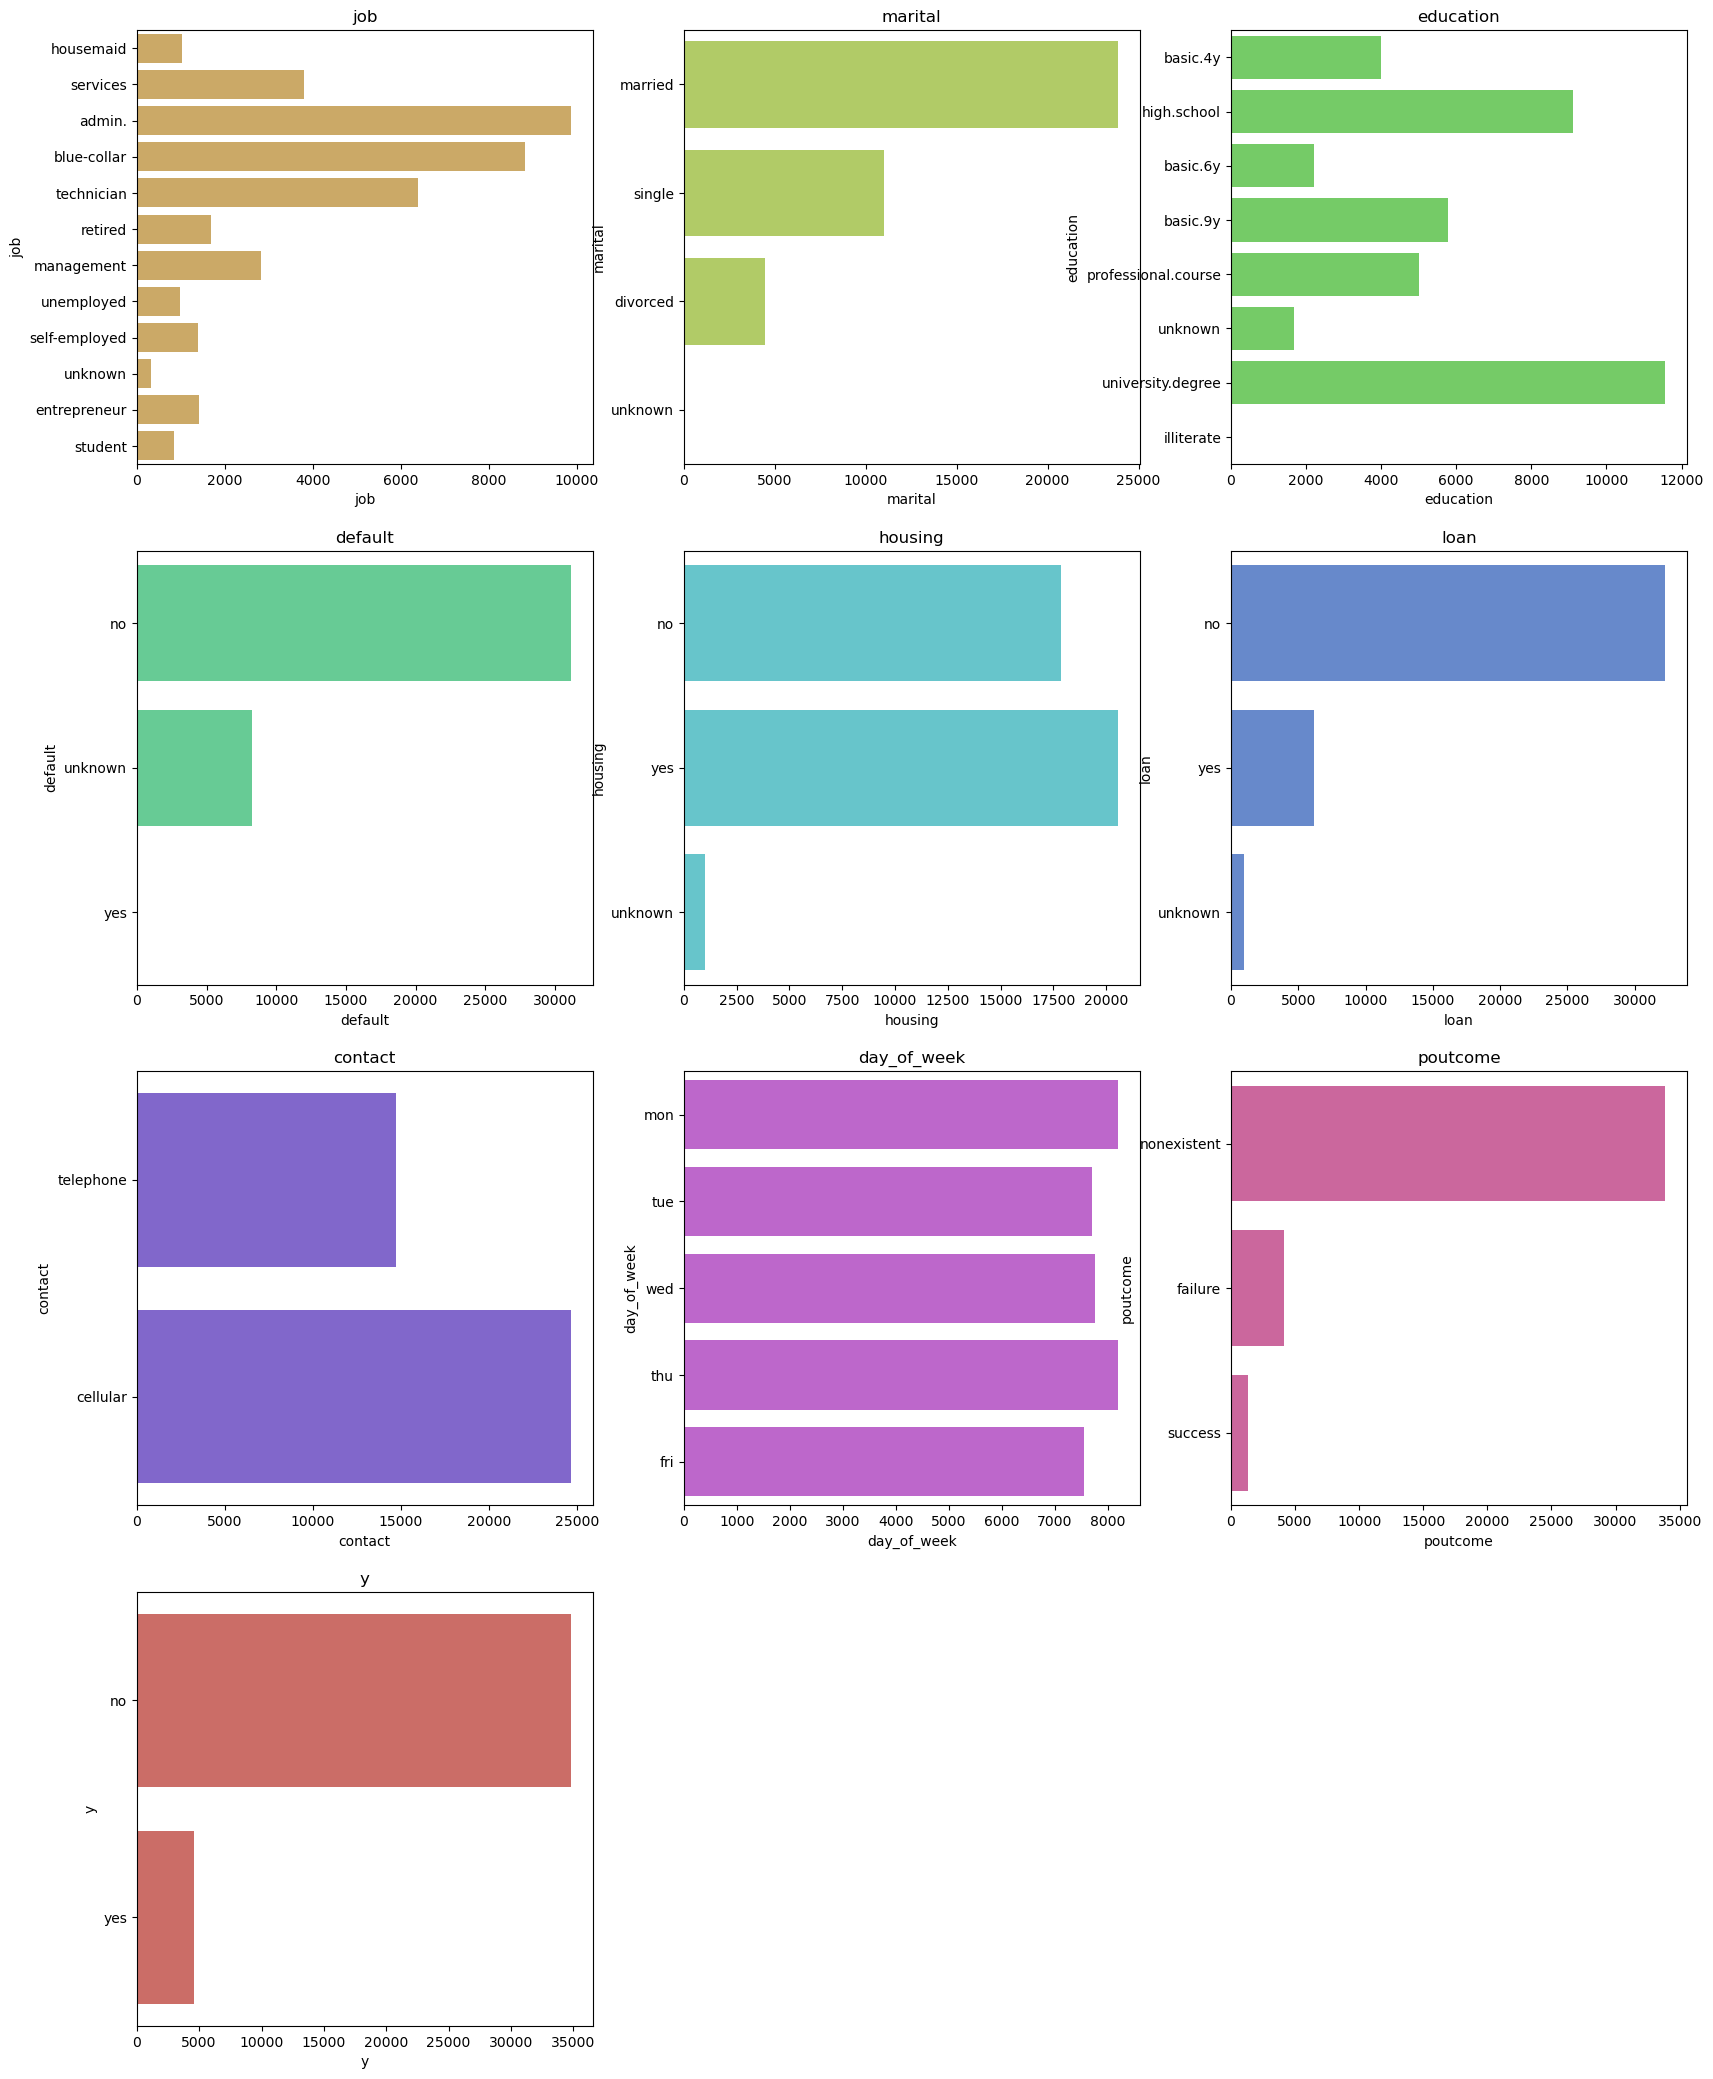

In [28]:
plt.figure(figsize=(20,80), facecolor = 'white')
plotnumber=1
color_palette = sns.color_palette("hls", len(categorical_columns))  # Adjust the palette as needed

for categorical_column in categorical_columns:
    ax = plt.subplot(12,3,plotnumber)
    sns.countplot(y=categorical_column, data=data, ax=ax, color=color_palette[plotnumber % len(color_palette)])
    plt.xlabel(categorical_column)
    plt.title(categorical_column)
    plotnumber+=1

plt.show()

*OBSERVACIONES:*
- Los trabajos predominantes en la clientela son de tipo **admin, blue-collar** y **technician**.
- La mayoría de los clientes están **casados**.
- La mayoría de los clientes tienen un título **universitario** o han alcanzado como máximo un estudio **secundario completo**.
- La gran mayoría de los clientes **no ha solicitado préstamos o no tiene préstamos pendientes**, pero cuando a housing (hipoteca) se refiere, hay una distribución similar entre aquellos que han solicitado y aquellos que no.
- La mayoría de las llamadas han sido realizadas a teléfonos celulares y en el mes de mayo.
- **Los resultados (outcome/label) no están balanceados, estamos en frente de un dataset DESBALANCEADO**.

### 3.3.2 First statistical analysis

In [31]:
statistical_analysis = data[categorical_columns].copy()

#### Categorical FEATURES analysis

We are going to **remove** the columns which have the highest number of unique variables. This will help us create a clearer visualization. If we included the variables 'job', 'month', and 'education' along with the rest, the combination of each job, education level, and month with the output (YES or NO) would result in too many plots, making the visualization too small and unreadable
The columns to drop are: **job, month and education.**

Therefore, we will visualize job, month and education in separate cells.

In [34]:
categorical_columns_removed = categorical_columns.copy()
columns_to_remove = ['job','education', 'y']
for column in columns_to_remove:
    categorical_columns_removed.remove(column)

categorical_columns_removed

['marital', 'default', 'housing', 'loan', 'contact', 'day_of_week', 'poutcome']

##### ***Plot for 'marital', 'default', 'housing', 'loan', 'contact', 'day_of_week', 'poutcome'***

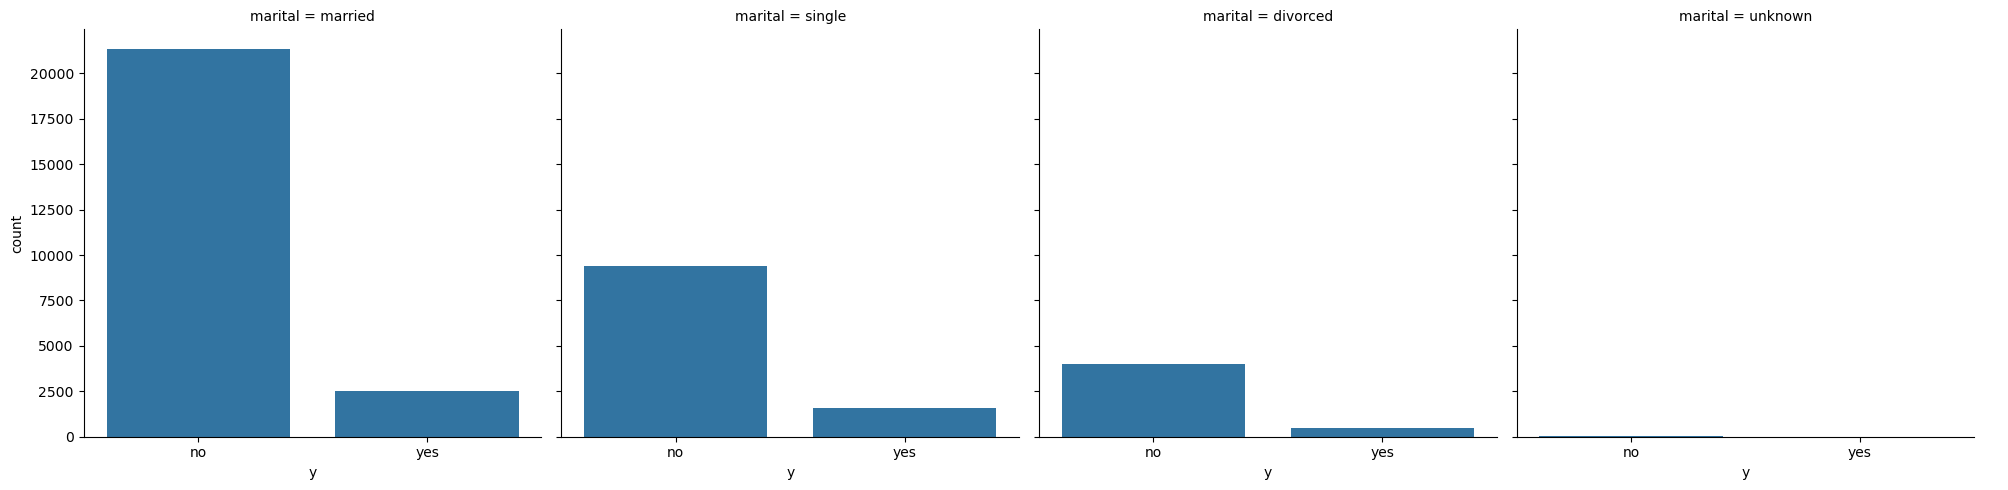

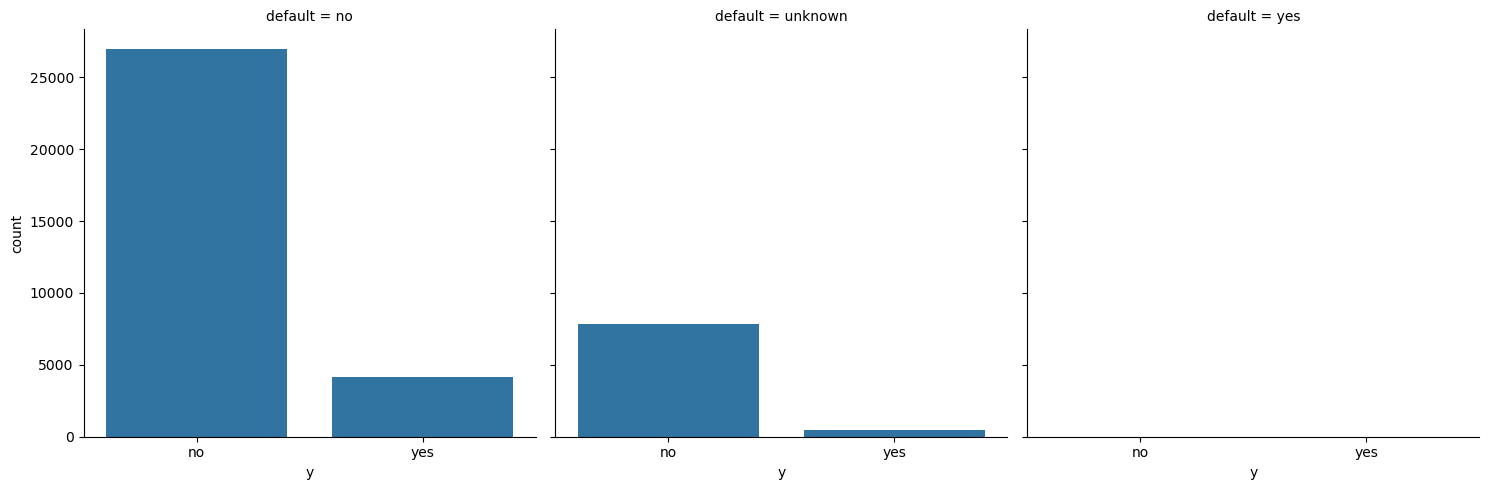

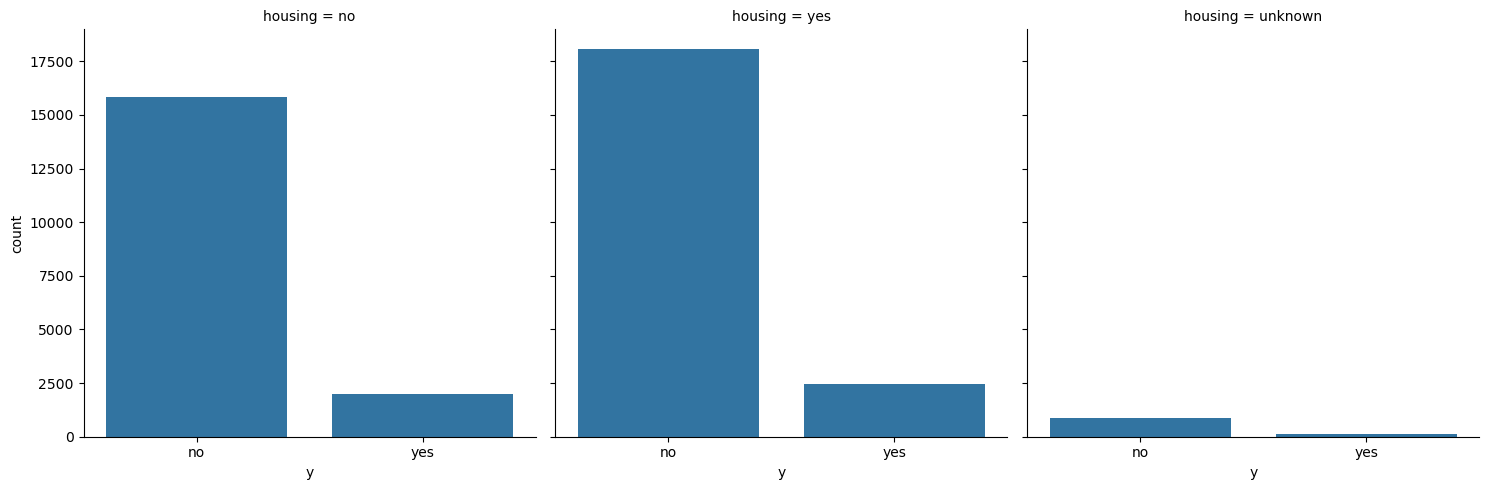

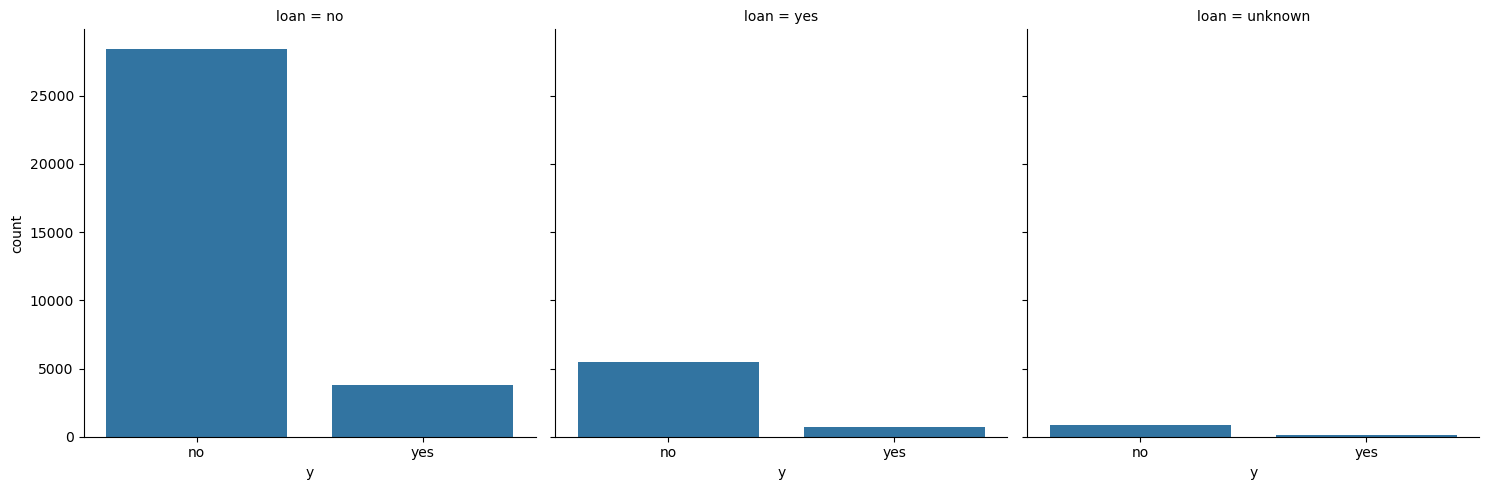

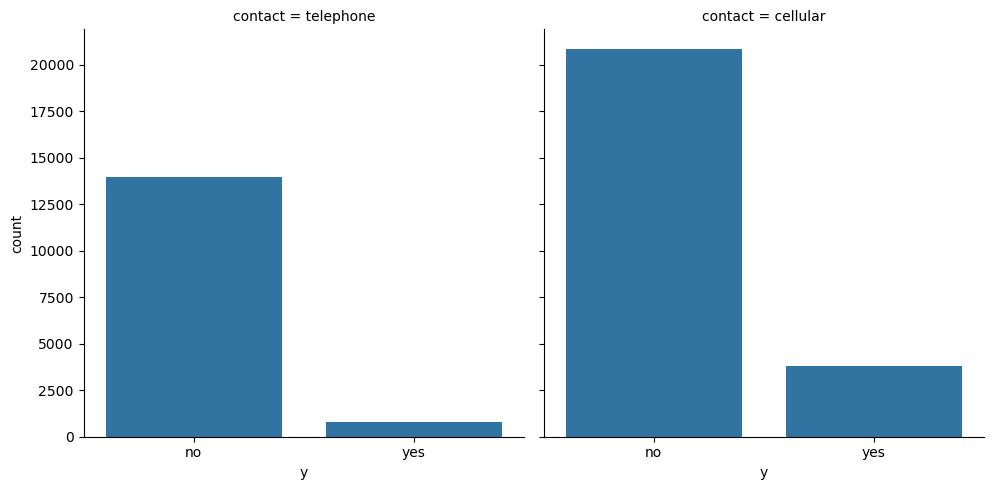

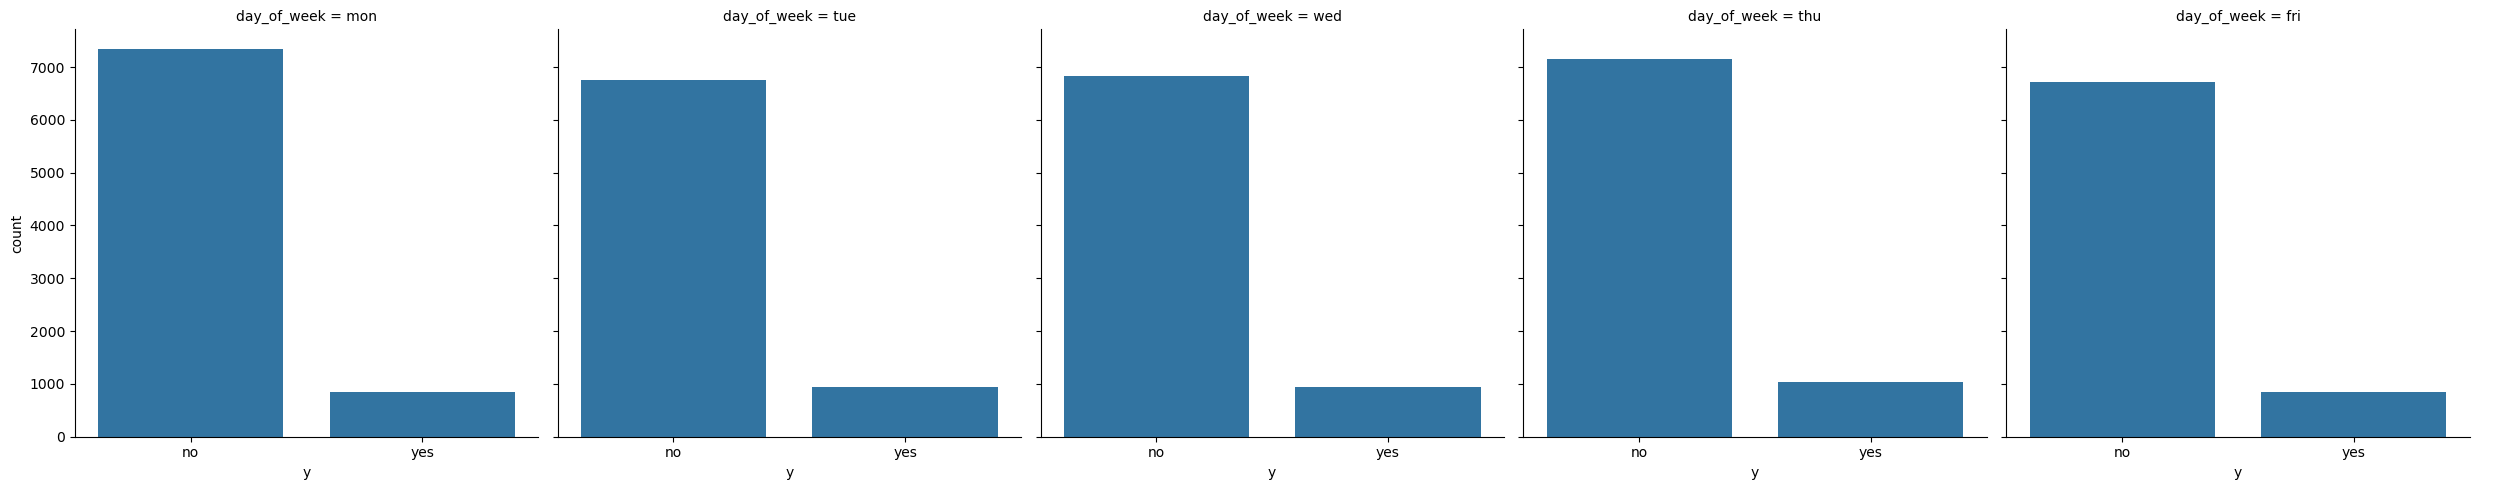

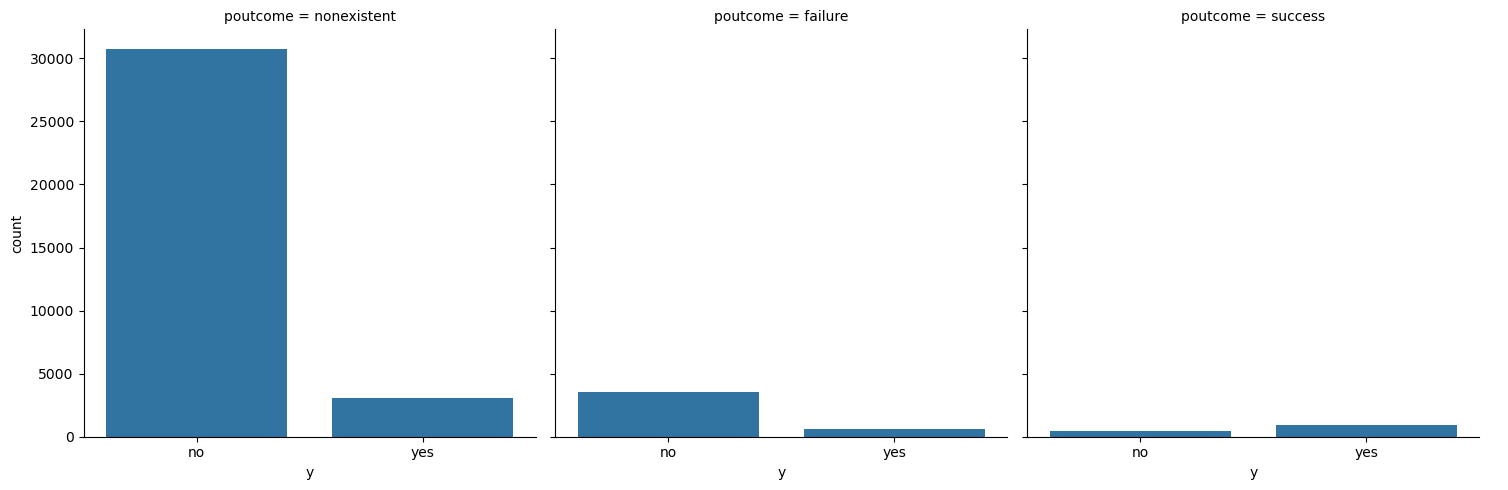

In [36]:
for column in categorical_columns_removed:
    sns.catplot(x='y', col=column, kind='count', data=data)

.



**We can not make any assumptions because since the data is so imbalanced, the comparisons may not result objective when we compare them to each other. Therefore, we decided to plot the percentual relation.**

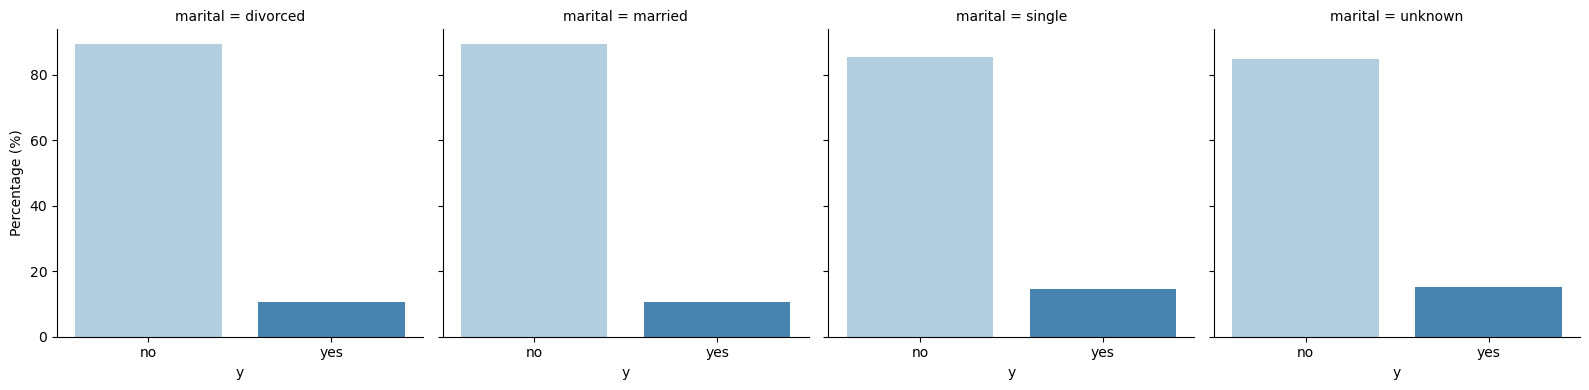

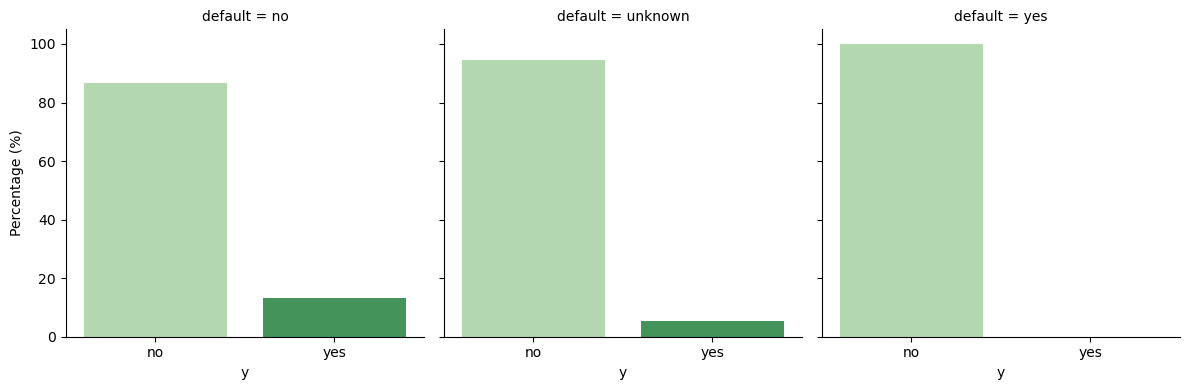

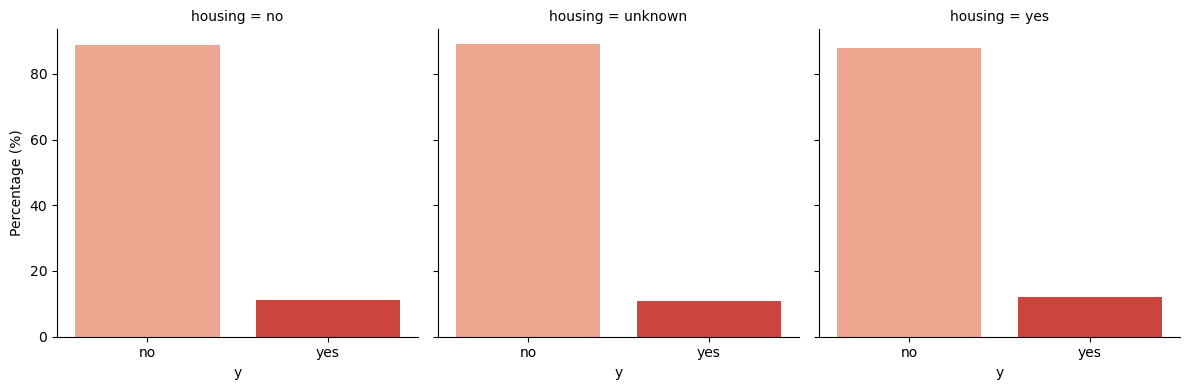

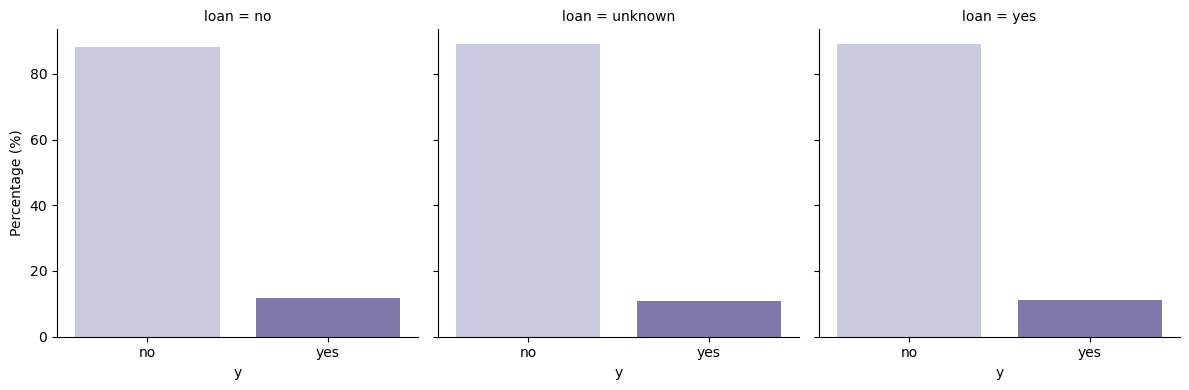

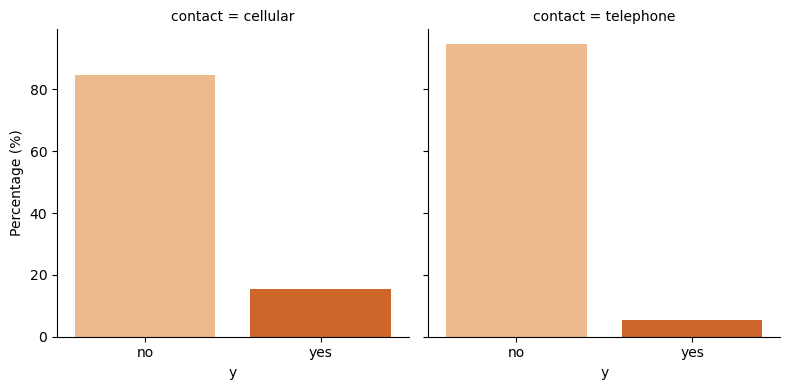

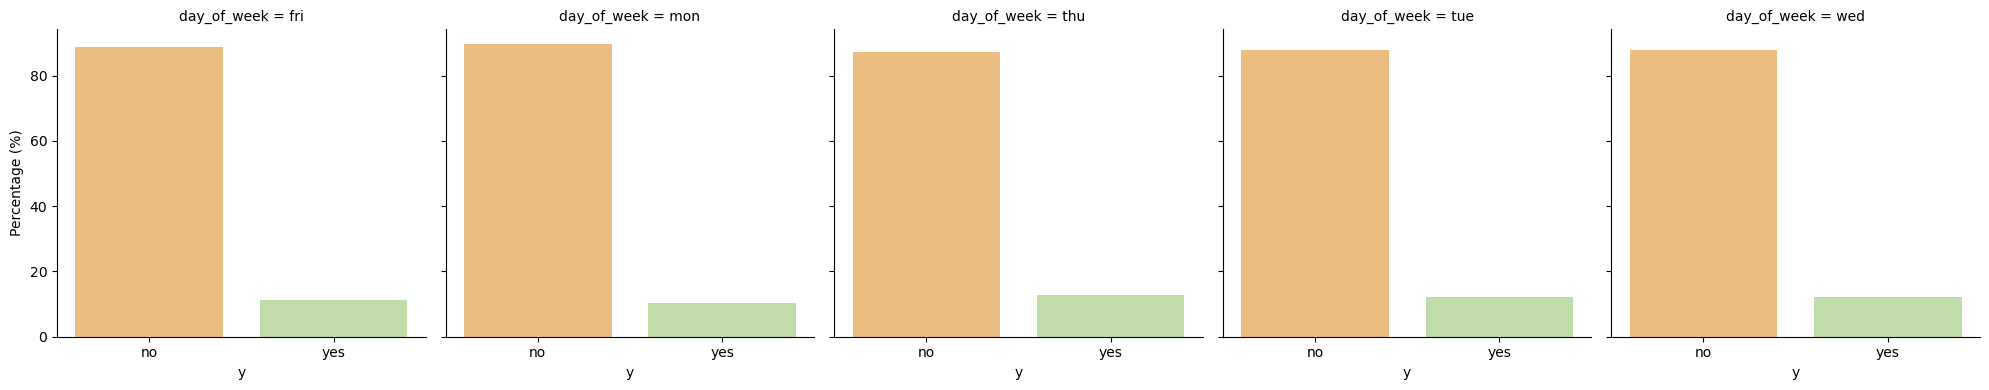

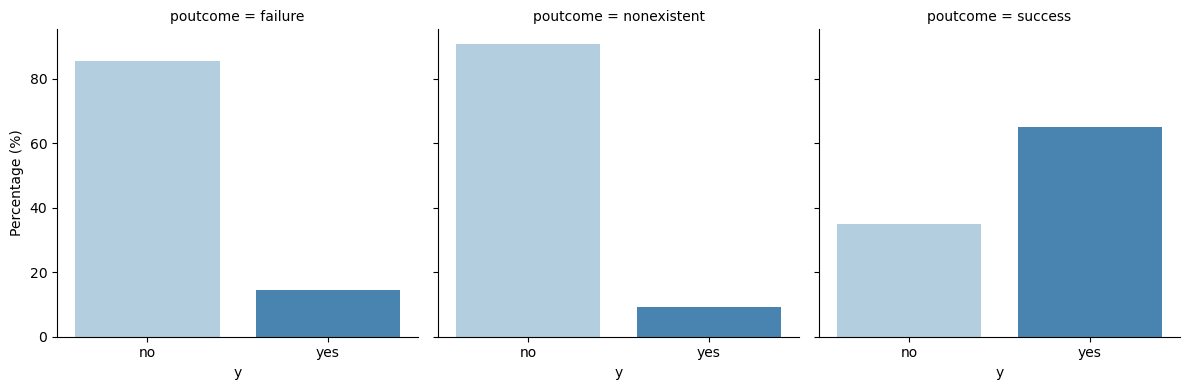

In [38]:

# List of palettes we want to use
palettes = ['Blues', 'Greens', 'Reds', 'Purples', 'Oranges', 'Spectral']

# Loop to plot the percentual relation between variables
for i, column in enumerate(categorical_columns_removed):
    # Create a normalized count table with percentages
    count_data = data.groupby([column, 'y']).size().reset_index(name='count')
    count_data['percent'] = count_data.groupby(column)['count'].transform(lambda x: x / x.sum() * 100)

    # Select a palette from the list
    palette = palettes[i % len(palettes)]  # This cycles through the list of palettes

    # Plot the percentages
    g = sns.catplot(x='y', y='percent', col=column, kind='bar', data=count_data, height=4, aspect=1, palette=palette)
    
    # Set the y-axis label and format
    g.set_axis_labels("y", "Percentage (%)")
    
    # Show the plot
    plt.show()


.

Takeaways: While there isn't a strict trend between the "YES" label and the other variables, we can conclude that:

- **Single** individuals are more likely to subscribe to a long-term deposit than **married** couples.
- People **not in credit default** show a higher tendency to subscribe to long-term deposits.
- Some variables, like the **day of the week** the call is made and whether the user has a **housing loan** or a **personal loan**, do not seem to influence the call's outcome.
- **Cellphones** are the preferred communication method.
- Most importantly, clients who had a **successful outcome in the previous campaign** are more likely to subscribe. Additionally, those who failed in the previous campaign are also more likely to subscribe compared to clients who have never been contacted before.


##### ***Plots for 'job', 'education', 'month'***

###### **JOB**

**In nominal terms:**

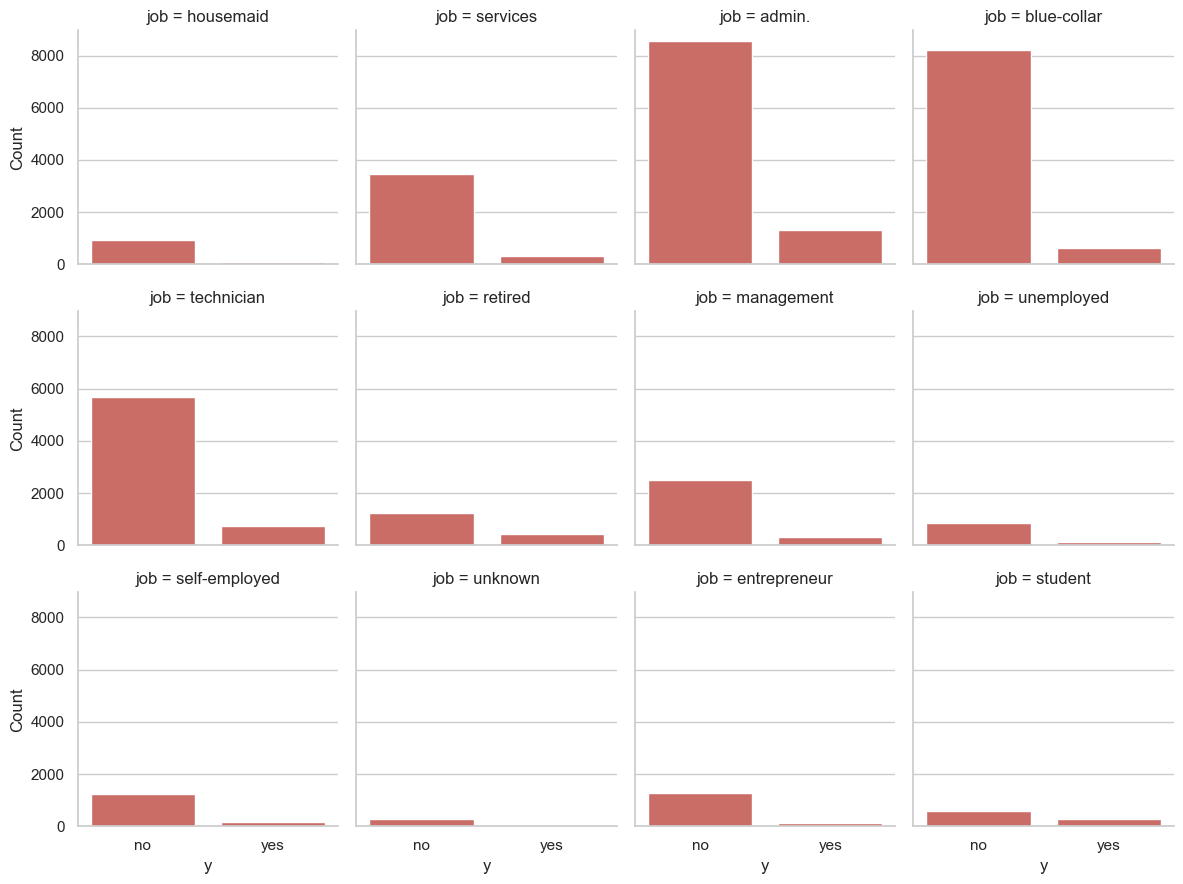

In [43]:
warnings.filterwarnings('ignore')

sns.set_theme(style="whitegrid")

palette = sns.color_palette("hls", len(data['y'].unique()))  # Adjust palette if needed

g = sns.FacetGrid(data, col="job", col_wrap=4, hue='y')
g.map(sns.countplot, "y", palette=palette)  # Pass the color palette
g.set_axis_labels("y", "Count")
plt.show()

**Percentually:**

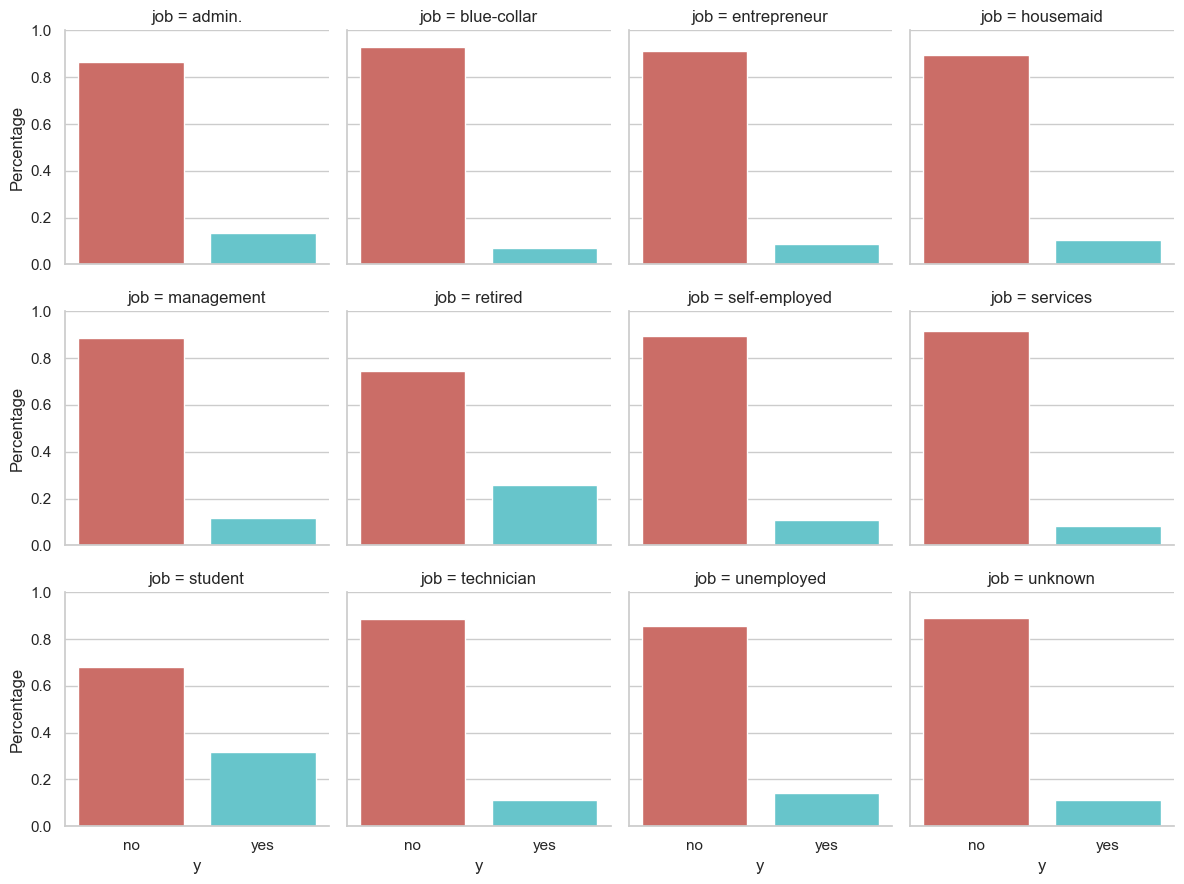

In [45]:
job_percent = data.groupby(['job','y'])
job_percent = job_percent.size() 
job_percent2 = job_percent.reset_index() #transform to df structure
job_percent2.columns = ['job', 'y', 'case_count'] #rename new column. By default it is named "0" and we can't manipulate it if it is not a string.
job_percent2['total_per_job'] = job_percent2.groupby(['job'])['case_count'].transform('sum') #create a column with the total of persons with each 
                                                                                            #job category
job_percent2['percentages'] = job_percent2['case_count'] / job_percent2['total_per_job'] #divide case_count by total_per_job to obtain the % distribution 
                                                                                        #of each job job
job_percent2

#now we plot the results by percent.
sns.set_theme(style="whitegrid")

palette = sns.color_palette("hls", len(job_percent2['y'].unique()))  # Adjust palette if needed

# Use sns.barplot instead of sns.countplot to plot the percentages
g = sns.FacetGrid(job_percent2, col="job", col_wrap=4, hue='y', sharey=True)
g.map(sns.barplot, "y", "percentages", palette=palette, order=job_percent2['y'].unique())  # Plot percentages
g.set_axis_labels("y", "Percentage")
g.set(ylim=(0, 1))  # Set y-axis limits from 0 to 1 for percentage scale
plt.show()


.

Take aways:

- **Students** and **retired** individuals have a higher tendency than the rest to suscribe to long term deposits.

###### **EDUCATION**

**In nominal terms:**

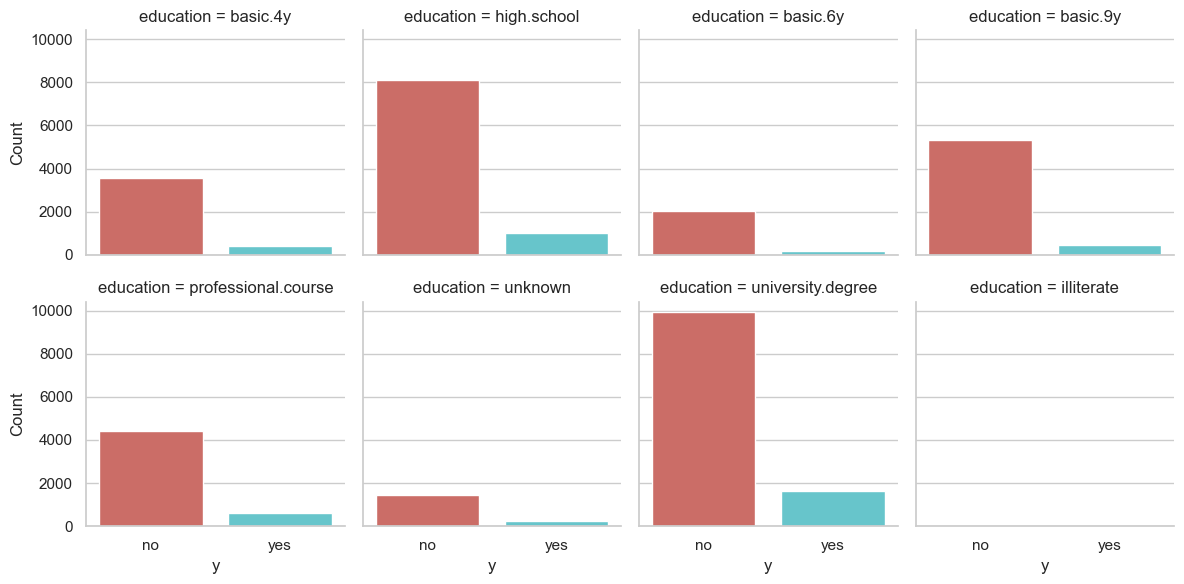

In [49]:
sns.set_theme(style="whitegrid")

palette = sns.color_palette("hls", len(data['y'].unique()))  # Adjust palette if needed

g = sns.FacetGrid(data, col="education", col_wrap=4)
g.map(sns.countplot, "y", palette=palette)  # Pass the color palette
g.set_axis_labels("y", "Count")
plt.show()

**Percentually:**

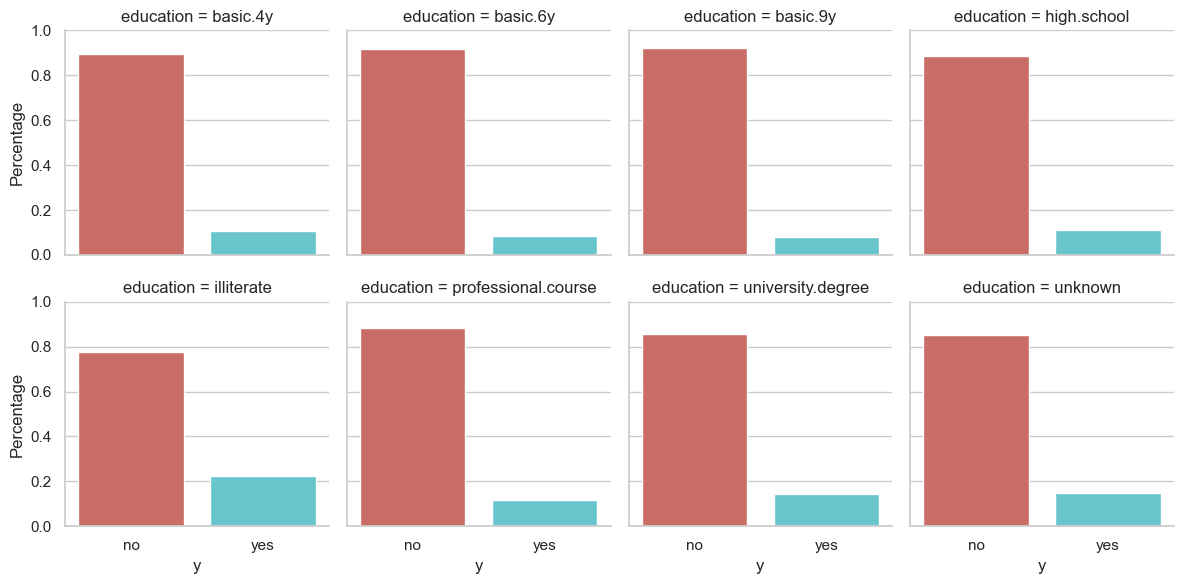

In [51]:
education_percent = data.groupby(['education','y'])
education_percent = education_percent.size() 
education_percent2 = education_percent.reset_index() #transform to df structure
education_percent2.columns = ['education', 'y', 'case_count'] #rename new column. By default it is named "0" and we can't manipulate it if it is not a string.
education_percent2['total_per_education'] = education_percent2.groupby(['education'])['case_count'].transform('sum') #create a column with the total of persons with each 
                                                                                            #job category
education_percent2['percentages'] = education_percent2['case_count'] / education_percent2['total_per_education'] #divide case_count by total_per_job to obtain the % distribution 
                                                                                        #of each job job
education_percent2

#now we plot the results by percent.
sns.set_theme(style="whitegrid")

palette = sns.color_palette("hls", len(education_percent2['y'].unique()))  # Adjust palette if needed

# Use sns.barplot instead of sns.countplot to plot the percentages
g = sns.FacetGrid(education_percent2, col="education", col_wrap=4, hue='y', sharey=True)
g.map(sns.barplot, "y", "percentages", palette=palette, order=education_percent2['y'].unique())  # Plot percentages
g.set_axis_labels("y", "Percentage")
g.set(ylim=(0, 1))  # Set y-axis limits from 0 to 1 for percentage scale
plt.show()

.

Take aways:

- **Illiterate** individuals have a higher tendency than the rest to suscribe to long term deposits than all of the rest.
- Individuals who:
  - have a **university degree**,
  - are **illiterate**
  - their **education level** is unknown

Seem to be the type of individuals with the best outcome.

###### **MONTH**

We want to examine the relationship between the month and the target variable. When plotting the nominal values for each month separately, the imbalance in the data makes it difficult to gather meaningful insights. It would be more effective to view the percentage relationship between the variables instead.

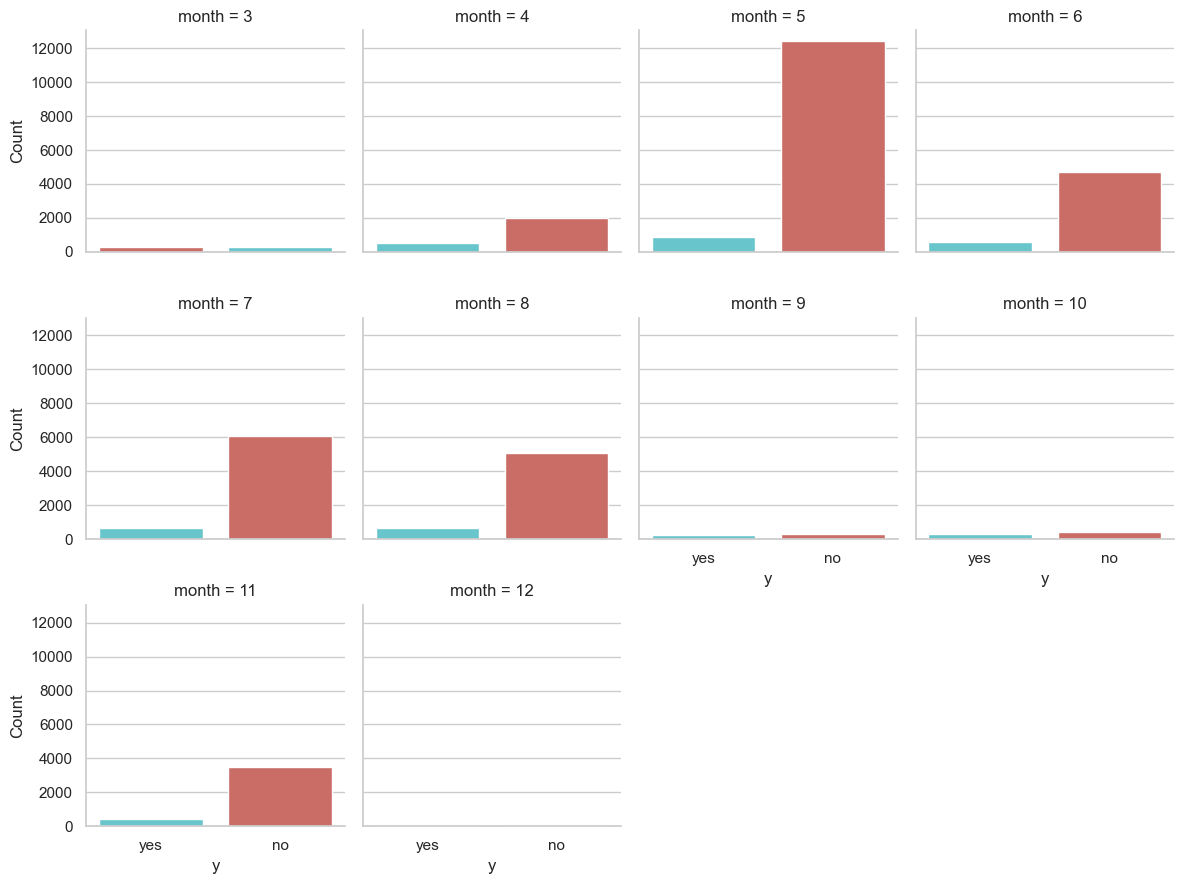

In [55]:
sns.set_theme(style="whitegrid")

palette = sns.color_palette("hls", len(data['y'].unique()))  # Adjust palette if needed
# data
g = sns.FacetGrid(data, col="month", col_wrap=4)
g.map(sns.countplot, "y", palette=palette)  # Pass the color palette
g.set_axis_labels("y", "Count")
plt.show()

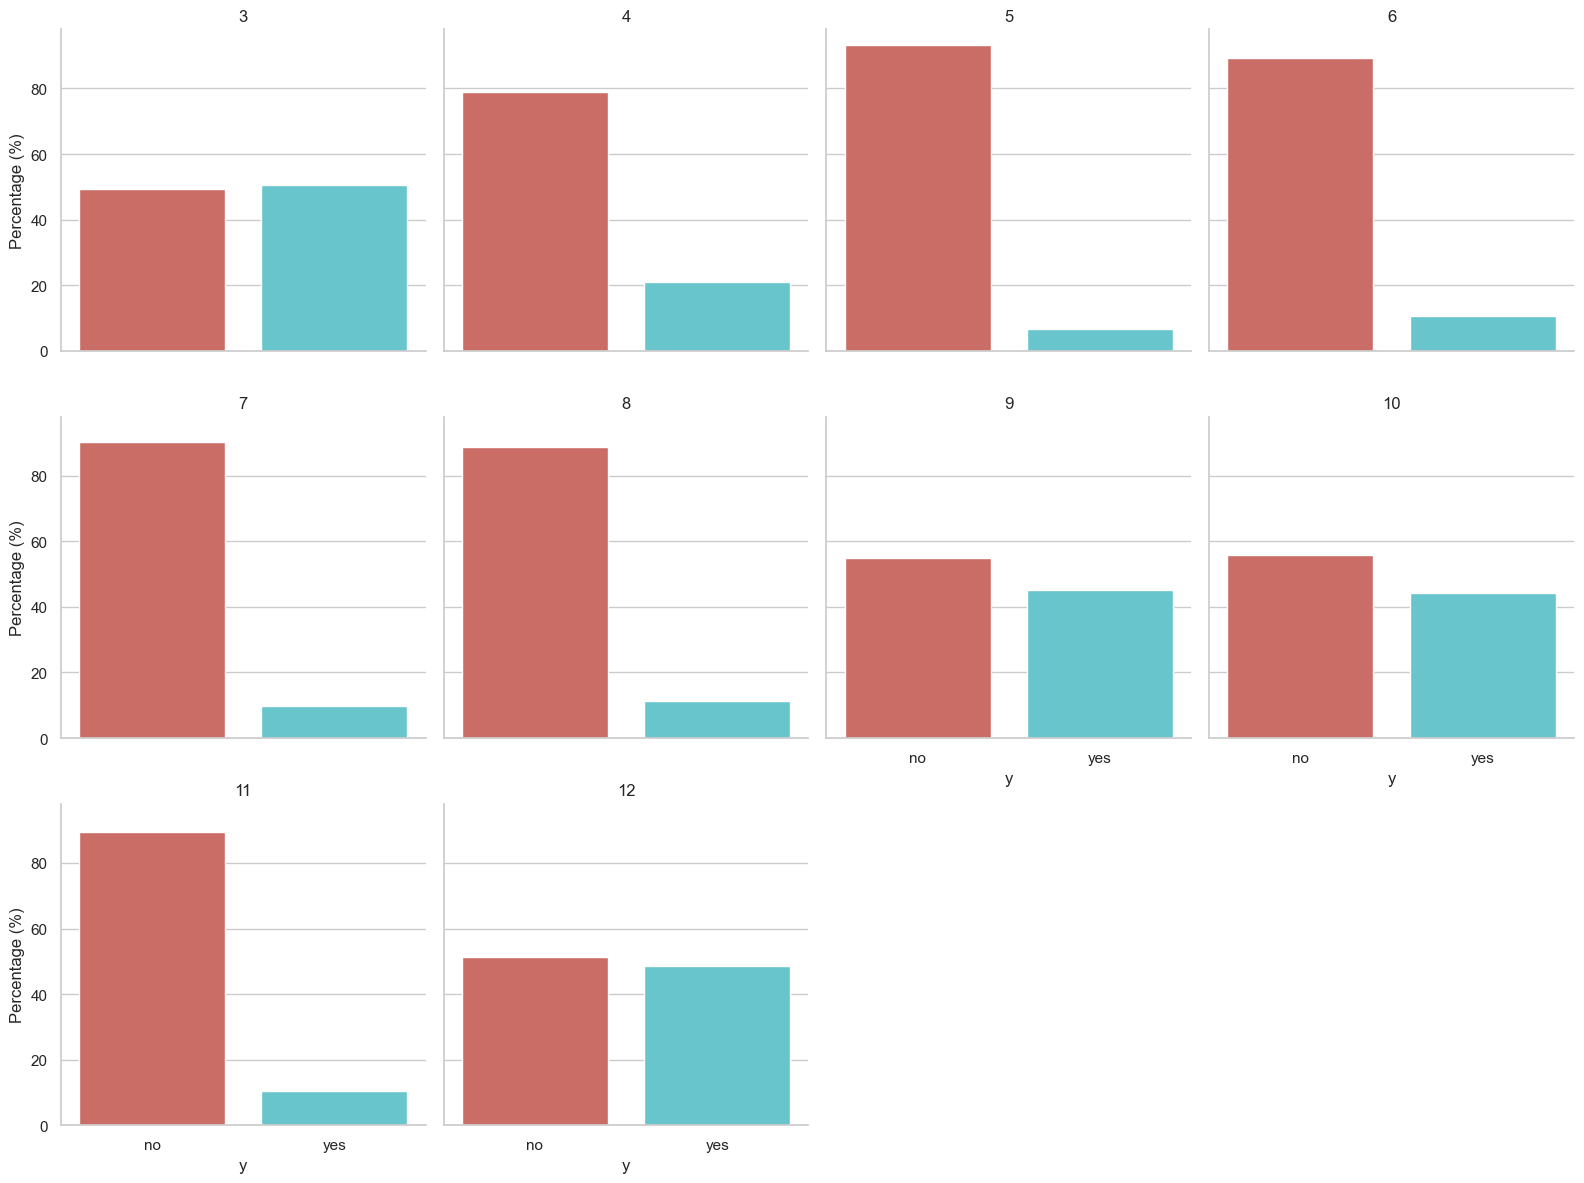

In [56]:
# Theme
sns.set_theme(style="whitegrid")

# Calculate percentual distribution within each month
count_data = data.groupby(['month', 'y']).size().reset_index(name='count')
count_data['percent'] = count_data.groupby('month')['count'].transform(lambda x: x / x.sum() * 100)

# Palette
palette = sns.color_palette("hls", len(data['y'].unique())) 

# Plot
g = sns.FacetGrid(count_data, col="month", col_wrap=4, height=4)
g.map(sns.barplot, "y", "percent", palette=palette)

# Set axis labels and titles
g.set_axis_labels("y", "Percentage (%)")
g.set_titles("{col_name}")
plt.show()

.

We can't use any month available to draw a conclusion. This is because the data between months is highly unbalanced, we don't have enough data to make an assumption. The only months we believe would work to make a conclusion are: 4-5-6-7-8-11.

After analyzing the % distribution in those months, we we not able to observe a clear trend.

.

It looks like MAY is the month in which they work the most. Why is that? We don't know. 

If we had to guess, we can say that it’s possible that the high number of calls in May is related to specific **commercial or financial strategies of the bank**. May might be a key month for attracting clients **before the summer holidays**, when many people tend to reduce their financial activities. Additionally, it could coincide with **promotional campaigns, the closing of the first fiscal semester, or a period when the bank evaluates the financial performance of the year so far**, motivating more deposit acquisitions. There may also be seasonal patterns in customer behavior, with May being a favorable month for investments.

.

Now we would like to analyze the data by month_Year.

In [60]:
# Group the data by year - month, and create a new column being the concatenation of both to have a name for our horizontal axis.
year_month_df_aux = data.groupby(['Year','month','y'])
year_month_df = year_month_df_aux.size() 
year_month_df = year_month_df.reset_index() #transforma a estructura de dataframe
year_month_df.columns.values[3] = 'case_count'
year_month_df['Year_month'] = year_month_df['Year'].astype(str) + '_' + year_month_df['month'].astype(str)
year_month_df


,Year,month,y,case_count,Year_month
0,2008,5,no,7287,2008_5
1,2008,5,yes,240,2008_5
2,2008,6,no,4129,2008_6
3,2008,6,yes,188,2008_6
4,2008,7,no,5806,2008_7
5,2008,7,yes,404,2008_7
6,2008,8,no,4462,2008_8
7,2008,8,yes,270,2008_8
8,2008,10,no,25,2008_10
9,2008,10,yes,42,2008_10


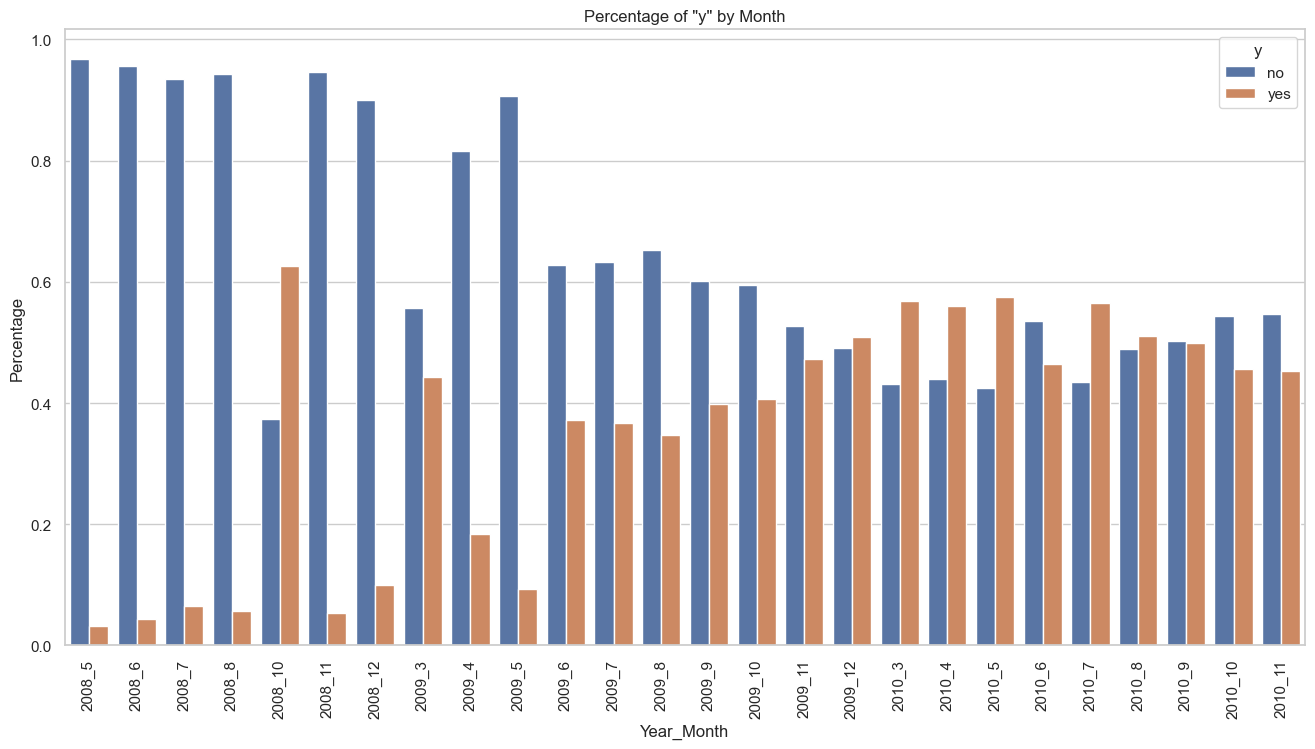

In [61]:
# Create a barplot showing a percentual relation between YES and NO as time passes (from 2008 to 2010)

test_df = year_month_df.copy()
test_df = test_df.drop(['Year','month'],axis=1)
test_df['totals_p_month'] = test_df.groupby(['Year_month'])['case_count'].transform('sum')
test_df['percentages'] = test_df['case_count'] / test_df['totals_p_month']

# Set the figure size (width, height)
plt.figure(figsize=(16, 8))

# Create the barplot
sns.barplot(x='Year_month', y='percentages', hue='y', data=test_df)

# Set labels and title
plt.xlabel('Year_Month')
plt.ylabel('Percentage')
plt.title('Percentage of "y" by Month')

# Rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)

# Show the plot
plt.show()

## 3.4 Numericals - Exploring the variables with PLOTS

### 3.4.1 Select the numeric type variables (int64 & float64) from our dataset

In [64]:
# Select columns of type int64 and float64
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f'There are {len(numeric_columns)} numeric columns (int64 and float64) \n\n')
for column in numeric_columns:
    unique_values = data[column].nunique()
    print(f"Column '{column}' has {unique_values} unique values.")


There are 11 numeric columns (int64 and float64) 


Column 'age' has 78 unique values.
Column 'month' has 10 unique values.
Column 'campaign' has 42 unique values.
Column 'pdays' has 27 unique values.
Column 'previous' has 8 unique values.
Column 'emp.var.rate' has 10 unique values.
Column 'cons.price.idx' has 26 unique values.
Column 'cons.conf.idx' has 26 unique values.
Column 'euribor3m' has 316 unique values.
Column 'nr.employed' has 11 unique values.
Column 'Year' has 3 unique values.


However, there are some variables that even though they have the "numerical" type, they are two **ordinal categorical column we should not take into consideration, and these the "month" and "Year" columns**

In [66]:
numeric_columns.remove("month") #removes month column
numeric_columns.remove("Year") #removes Year column
# numeric_columns.remove("duration") #removes duration column because it biases the data for our future ML model.

### 3.4.2 First statistical analysis

We can perform a symple statistical analysis to discover the main 

In [69]:
numeric_data = data[numeric_columns].copy()
numeric_data.describe() #provides statistical information such as: mean, std, min value, iq range, max value

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,39404.000000,39404.000000,39404.000000,39404.000000,39404.000000,39404.000000,39404.000000,39404.000000,39404.000000
mean,40.116105,2.618744,960.847097,0.178738,0.064067,93.577538,-40.499604,3.601243,5165.986481
std,10.460328,2.814780,190.869184,0.503172,1.577041,0.583820,4.644327,1.742337,72.763866
min,17.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.334000,5099.100000
50%,38.000000,2.000000,999.000000,0.000000,1.100000,93.798000,-41.800000,4.857000,5191.000000
75%,47.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


We can see that the only column with an inconsistent range of data is "pdays". We must be careful with how we treat this column.

##### Age analysis

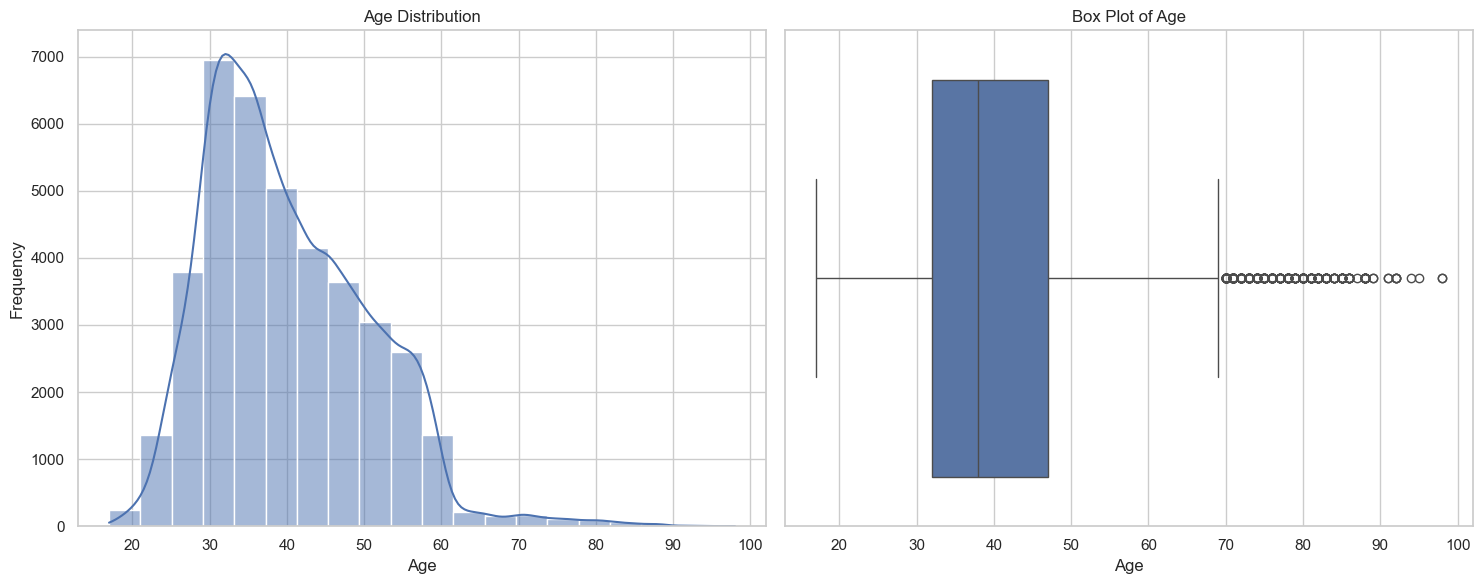

In [72]:
#Create fig to contain the plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Histograma en el primer subplot
sns.histplot(numeric_data['age'], bins=20, kde=True, ax=axes[0])
axes[0].set_title('Age Distribution')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')

# Box plot en el segundo subplot
sns.boxplot(x=numeric_data['age'], ax=axes[1])
axes[1].set_title('Box Plot of Age')
axes[1].set_xlabel('Age')

# Mostrar los gráficos
plt.tight_layout()
plt.show()

##### Other columns

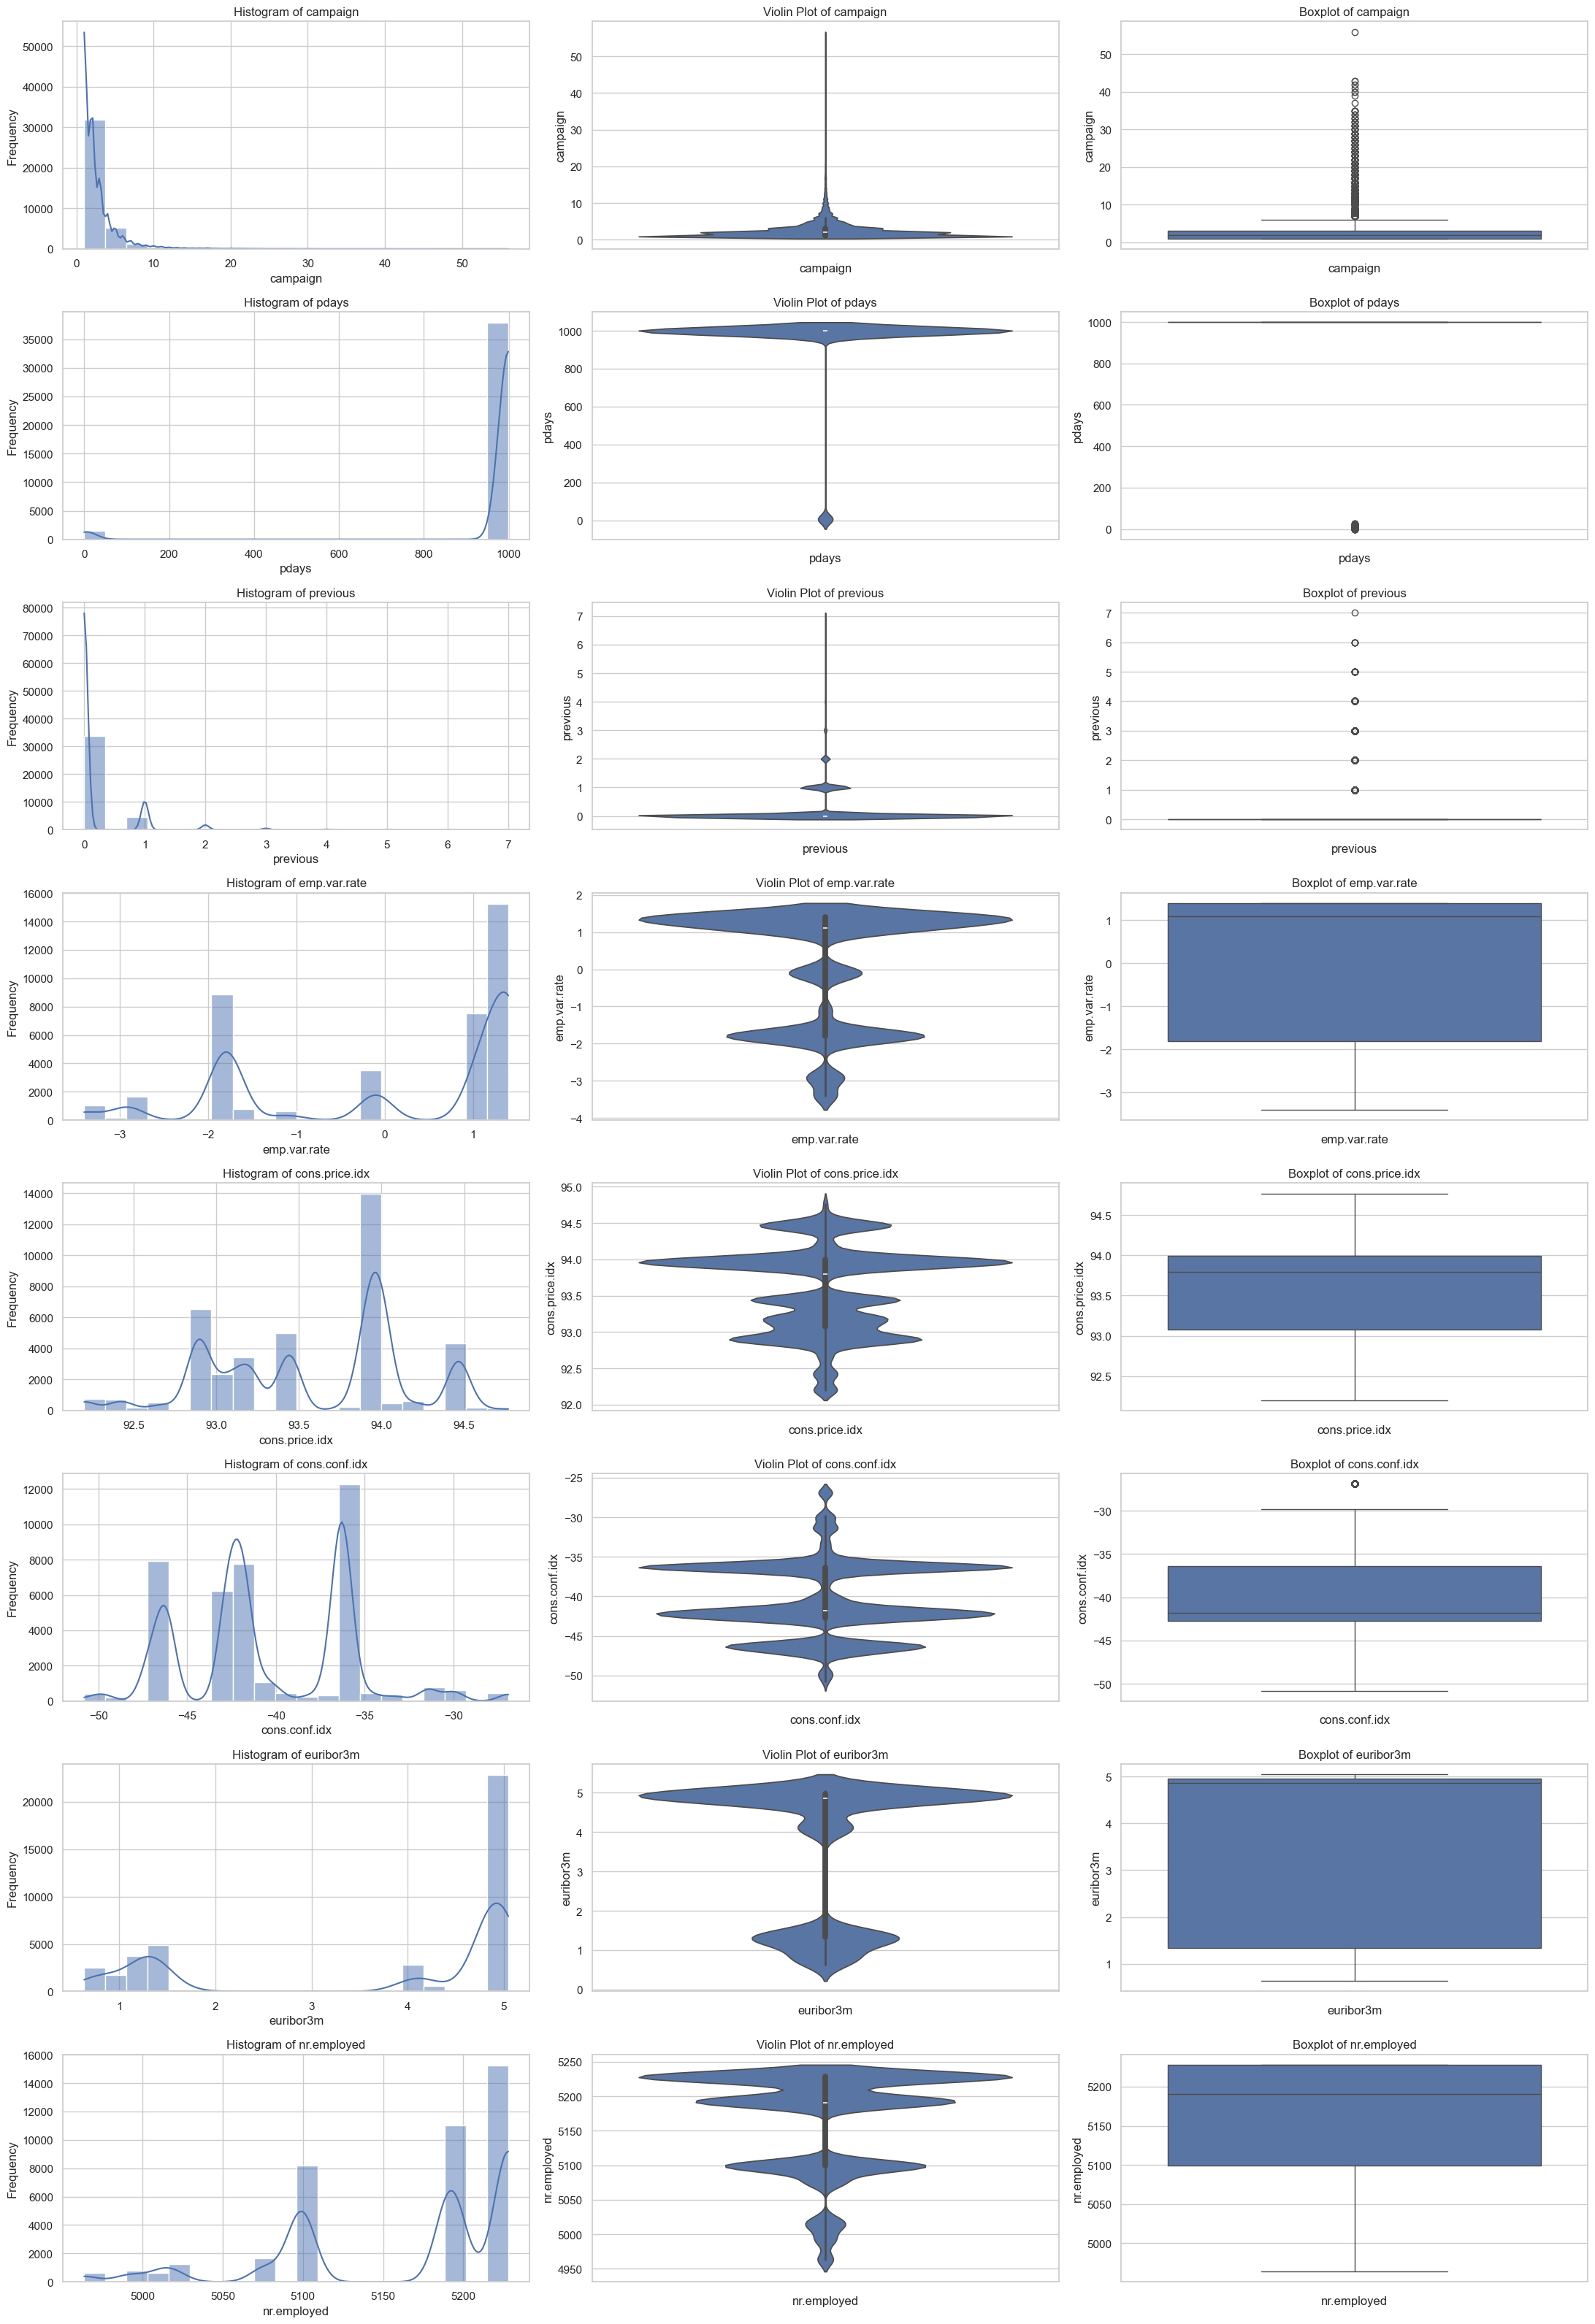

In [74]:
# List of variables to plot
variables = ['campaign', 'pdays', 'previous', 'emp.var.rate', 
             'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

# Create the figure and subplots (3 columns for each variable: histogram, violin plot, boxplot)
fig, axes = plt.subplots(len(variables), 3, figsize=(22, 4 * len(variables)))

# Loop through each variable and create the histogram, violin plot, and boxplot
for i, var in enumerate(variables):
    # Histogram in the first column
    sns.histplot(numeric_data[var], bins=20, kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Histogram of {var}')
    axes[i, 0].set_xlabel(var)
    axes[i, 0].set_ylabel('Frequency')
    
    # Violin plot in the second column
    sns.violinplot(y=numeric_data[var], ax=axes[i, 1])
    axes[i, 1].set_title(f'Violin Plot of {var}')
    axes[i, 1].set_xlabel(var)
    
    # Boxplot in the third column
    sns.boxplot(y=numeric_data[var], ax=axes[i, 2])
    axes[i, 2].set_title(f'Boxplot of {var}')
    axes[i, 2].set_xlabel(var)

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()


We can see that the other variables are numerical and have a low number of unique values. However, they should still be treated as numerical because they represent rates with quantitative significance that can vary over time.

Additionally, the rest of the columns **do not have a normal distribution**. This is important because when we decide to normalize our data, a common practice is to use Z-Score normalization. However, this assumes our data is normally distributed, which is not our case. For that reason, we are going to use the MinMaxScaling normalization.

<!-- Reasons: -->
- It is Not Normally Distributed: Since most of our columns, except for Age, are not normally distributed, Z-score normalization might not be the best fit, as it assumes normality.

- It has No Significant Outliers: MinMaxScaling is succeptible to outliers. However, As we can observe in our plots, we do not have significant outliers except for columns "pdays" and "previous". We can eliminate the outliers from our dataset to allow a better visualization.

### 3.4.3 Detect outliers

In [77]:
# Identify outliers using the IQR method for pdays, previous and campaign
# For visualization purposed, we are probably going to remove a high number of data.
# The outlier detection will be further enhanced in future iterations in our notebook.
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.05)
    Q3 = data[column].quantile(0.95)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

pdays_outliers = detect_outliers_iqr(numeric_data, 'pdays')
previous_outliers = detect_outliers_iqr(numeric_data, 'previous')
campaign_outliers = detect_outliers_iqr(numeric_data, 'campaign')

# print(f"Outliers in 'pdays': \n{pdays_outliers}\n")
# print(f"Outliers in 'previous': \n{previous_outliers}\n")
# print(f"Outliers in 'previous': \n{campaign_outliers}\n")

.

**Now we know how many rows are considered outliers... but is it actually worth it to drop those columns? Let's check how many "YES" from the target column actually are contained within this outliers:**


#### **Analysis for column "previous":**

In [80]:
previous_y = data.groupby(["previous","y"])
previous_y = previous_y.size() 
previous_y2 = previous_y.reset_index() #transform to df structure
previous_y2.columns = ['previous', 'y', 'case_count'] #rename new column. By default it is named "0" and we can't manipulate it if it is not a string.
previous_y2['total_per_previous'] = previous_y2.groupby(['previous'])['case_count'].transform('sum') #create a column with the total of persons with each 
                                                                                            #job category
previous_y2['percentages'] = previous_y2['case_count'] / previous_y2['total_per_previous'] 
previous_y2

,previous,y,case_count,total_per_previous,percentages
0,0,no,30757,33858,0.908412
1,0,yes,3101,33858,0.091588
2,1,no,3519,4484,0.784790
3,1,yes,965,4484,0.215210
4,2,no,402,752,0.534574
5,2,yes,350,752,0.465426
6,3,no,88,216,0.407407
7,3,yes,128,216,0.592593
8,4,no,32,70,0.457143
9,4,yes,38,70,0.542857


#### **Analysis for column "pdays":**

In [82]:
pdays_y = data.groupby(["pdays","y"])
pdays_y = pdays_y.size() 
pdays_y2 = pdays_y.reset_index() #transform to df structure
pdays_y2.columns = ['pdays', 'y', 'case_count'] #rename new column. By default it is named "0" and we can't manipulate it if it is not a string.
pdays_y2['total_per_pdays'] = pdays_y2.groupby(['pdays'])['case_count'].transform('sum') #create a column with the total of persons with each 
                                                                                            #job category
pdays_y2['percentages'] = pdays_y2['case_count'] / pdays_y2['total_per_pdays']
pdays_y2

,pdays,y,case_count,total_per_pdays,percentages
0,0,no,5,15,0.333333
1,0,yes,10,15,0.666667
2,1,no,18,26,0.692308
3,1,yes,8,26,0.307692
4,2,no,24,61,0.393443
5,2,yes,37,61,0.606557
6,3,no,140,438,0.319635
7,3,yes,298,438,0.680365
8,4,no,55,118,0.466102
9,4,yes,63,118,0.533898


#### **Analysis for column "campaign":**

In [84]:
campaign_y = data.groupby(["campaign","y"])
campaign_y = campaign_y.size() 
campaign_y2 = campaign_y.reset_index() #transform to df structure
campaign_y2.columns = ['campaign', 'y', 'case_count'] #rename new column. By default it is named "0" and we can't manipulate it if it is not a string.
campaign_y2['total_per_campaign'] = campaign_y2.groupby(['campaign'])['case_count'].transform('sum') #create a column with the total of persons with each 
                                                                                            #job category
campaign_y2['percentages'] = campaign_y2['case_count'] / campaign_y2['total_per_campaign']
campaign_y2

,campaign,y,case_count,total_per_campaign,percentages
0,1,no,14098,16368,0.861315
1,1,yes,2270,16368,0.138685
2,2,no,9022,10223,0.882520
3,2,yes,1201,10223,0.117480
4,3,no,4658,5230,0.890631
5,3,yes,572,5230,0.109369
6,4,no,2376,2625,0.905143
7,4,yes,249,2625,0.094857
8,5,no,1466,1586,0.924338
9,5,yes,120,1586,0.075662


#### **Conclusions:**

.
.

Given the significant imbalance in our data, we believe it is not advisable to eliminate all rows classified as outliers. This is because, as the values for "previous" and "pdays" increase, the percentage of "YES" responses also rises.

As a result, we have decided to drop only one column: campaign. For the other two columns, previous and pdays, we will convert them into categorical variables with the following classifications:

**Previous (4 clusters):**

- 0 (0)
- 1 (1)
- 2 (2)
- 3-7 (more_than_2)
  
**Pdays (3 clusters):**

- 999 (first_call)
- 1-10 (one_to_ten_days)
- 11+ (more_than_10_days)

  
We will remove outliers from the campaign column, as they are minimal and do not significantly affect the "YES" outcomes. There appears to be no strong correlation between a high number of campaigns and a positive response.

### 3.4.4 Correlation Analysis

#### 3.4.4.1 Remove outliers for corr plot

Given that our dataset has values with different ranges across each column, it is advisable to normalize the data before performing a correlation analysis. This will facilitate a more objective evaluation.

To enhance the objectivity of our analysis, we will **remove the outliers and the "pdays" column**, as we are uncertain how to interpret the value of 999 days. This indicates that it would be the first time the client is contacted, but it represents the highest value in the column, with over 90% of the data clustered around it. Therefore, we cannot simply eliminate those values.


In [90]:
def detect_outliers_iqr2(data, column): #almost same name as the other function, but this time we name it with a 2. 
                                        #Reason: the return is different, it returns 2 values (temporary and new data for DF)
    Q1 = data[column].quantile(0.05)
    Q3 = data[column].quantile(0.95)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Create a mask for outliers
    outliers_mask = (data[column] < lower_bound) | (data[column] > upper_bound)
    
    return data[outliers_mask], data[~outliers_mask]  # Return outliers and cleaned data. The "~" symbol acts as a NOT, because it 
                                                    # inverts the outliers_mask.
                                                    # This will return the TRUE values and the NON true values when finding outliers.

# Detect outliers and remove them. The coding is similar, but this time we added a number "2" to show differentiate them.
pdays_outliers2, numeric_data_cleaned2 = detect_outliers_iqr2(numeric_data, 'pdays')
previous_outliers2, numeric_data_cleaned2 = detect_outliers_iqr2(numeric_data_cleaned2, 'previous')
campaign_outliers2, numeric_data_cleaned2 = detect_outliers_iqr2(numeric_data_cleaned2, 'campaign')

# Apply Min-Max Scaling
scaler = MinMaxScaler()
numeric_data_normalized = numeric_data_cleaned2.copy()  # Create a copy of the cleaned data
numeric_data_normalized[numeric_data_normalized.columns] = scaler.fit_transform(numeric_data_normalized)

# Display the shape of the cleaned and normalized DataFrame
print(f"Cleaned DataFrame shape: {numeric_data_cleaned2.shape}")



Cleaned DataFrame shape: (37521, 9)


#### 3.4.4.2 Correlation plot with data as is

 The columns that are going to be analyzed are: ['age', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


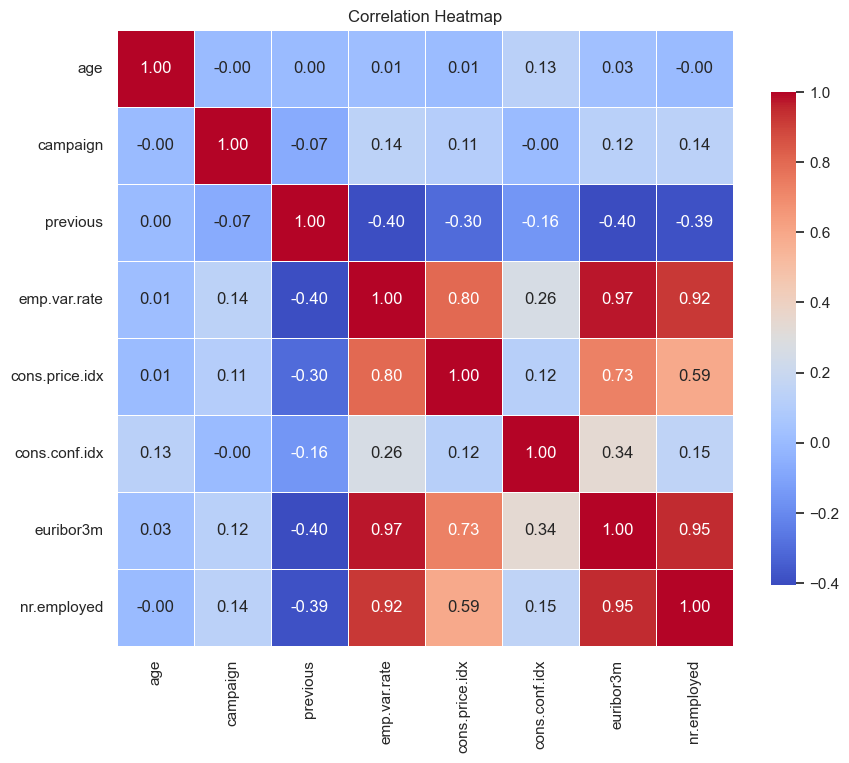

In [92]:
columns_for_correlation = numeric_data_cleaned2.columns.tolist() #columns of interest to plot
columns_for_correlation.remove('pdays')
print(f' The columns that are going to be analyzed are:', columns_for_correlation) 


# Calculate the correlation matrix
correlation_matrix = numeric_data_cleaned2[columns_for_correlation].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, 
            cbar_kws={"shrink": .8}, linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

#### 3.4.4.3 Correlation plot with normalized data

 The columns that are going to be analyzed are: ['age', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


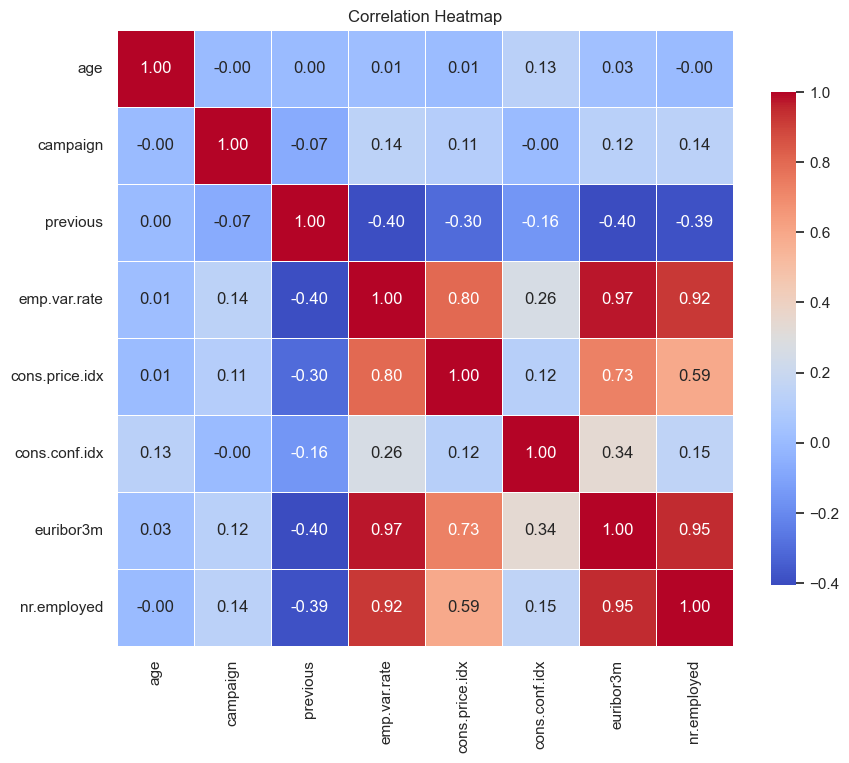

In [94]:
columns_for_correlation = numeric_data_normalized.columns.tolist() #columns of interest to plot
columns_for_correlation.remove('pdays')
print(f' The columns that are going to be analyzed are:', columns_for_correlation) 


# Calculate the correlation matrix
correlation_matrix = numeric_data_normalized[columns_for_correlation].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, 
            cbar_kws={"shrink": .8}, linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


#### 3.4.4.4 Conclusion from our correlation analysis (in spanish and english):

##### **ENGLISH**:

1. **Strong Positive Correlations:**
- euribor3m and emp.var.rate: Very high correlation (0.97), indicating that as the three-month Euribor rate increases, the employment variation rate tends to increase as well.
- emp.var.rate and nr.employed: Also very high (0.92), suggesting that higher employment variation corresponds with a higher number of employed individuals.
- euribor3m and nr.employed: Strong correlation (0.95), reinforcing the relationship with employment.
  
2. **Moderate Correlations:** cons.price.idx and emp.var.rate (0.80) and cons.price.idx and euribor3m (0.73) suggest that price indices and employment variables are somewhat interlinked, possibly indicating economic factors affecting both.

3. **Negative Correlations:** The variable previous (which indicates the number of times the bank has contacted a customer before) has a negative relationship with emp.var.rate (the employment variation rate). This means that when there is a higher number of previous contacts, there tends to be a lower variation in employment.
The same occurs between previous and euribor3m. A higher number of previous contacts is also related to lower Euribor rates.
Additionally, there is a negative correlation between previous and nr.employed (the number of employees). This suggests that as the number of previous contacts increases, the number of employed individuals tends to decrease.

4. **Minimal Correlation:** age, campaign, and previous have very weak correlations with most other variables, suggesting they may not have a strong impact on the dependent variable.

5. **Campaign Effect:** The "campaign" variable shows weak relationships with most others, hinting that it might not significantly influence other factors, particularly the target variable "y."


**Summary:**
The matrix indicates strong relationships among economic indicators, while variables related to previous customer interactions (like previous and pdays) have notable negative correlations with these indicators.
The weak correlations of age and campaign suggest they may not be as relevant for predicting the target variable compared to economic factors.

##### ESPAÑOL:
1. **Correlaciones Positivas Fuertes:**
- euribor3m y emp.var.rate: Correlación muy alta (0.97), lo que indica que a medida que aumenta la tasa Euribor a tres meses, la tasa de variación de - empleo también tiende a aumentar.
- emp.var.rate y nr.employed: También muy alta (0.92), sugiriendo que una mayor variación de empleo corresponde con un mayor número de personas empleadas.
- euribor3m y nr.employed: Fuerte correlación (0.95), reforzando la relación con el empleo.

2. **Correlaciones Moderadas:** cons.price.idx y emp.var.rate (0.80) y cons.price.idx y euribor3m (0.73) sugieren que los índices de precios y las variables de empleo están algo interrelacionados, posiblemente indicando factores económicos que afectan a ambos.

3. **Correlaciones Negativas:** La variable previous (que indica el número de veces que el banco ha contactado a un cliente previamente) tiene una relación negativa con emp.var.rate (la tasa de variación de empleo). Esto significa que cuando hay un mayor número de contactos previos, tiende a haber una menor variación en el empleo. Lo mismo ocurre entre previous y euribor3m. Un mayor número de contactos previos también está relacionado con tasas Euribor más bajas. Además, hay una correlación negativa entre previous y nr.employed (el número de empleados). Esto sugiere que a medida que aumenta el número de contactos previos, el número de empleados tiende a disminuir.

4. **Correlación Mínima:** age, campaign y previous tienen correlaciones muy débiles con la mayoría de las otras variables, lo que sugiere que pueden no tener un gran impacto en la variable dependiente.

5. **Efecto de Campaign:** La variable "campaign" muestra relaciones débiles con la mayoría de las demás, insinuando que podría no influir significativamente en otros factores, particularmente en la variable objetivo "y".

**Resumen:** La matriz indica fuertes relaciones entre los indicadores económicos, mientras que las variables relacionadas con interacciones previas con los clientes (como previous y pdays) tienen correlaciones negativas notables con estos indicadores. Las correlaciones débiles de age y campaign sugieren que pueden no ser tan relevantes para predecir la variable objetivo en comparación con los factores económicos.